In [1]:
import lucem_illud #Special module written for this class

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import matplotlib.colors # For nice colours
import wordcloud
import numpy as np
import scipy
import glob
import seaborn as sns
import sklearn.manifold
import itertools
import json
import ast
import urllib.parse
from bs4 import BeautifulSoup as bs
import spacy #comp-linguistics
import graphviz #displays the graphs
import gensim#For topic modeling

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#To process text data
import re
import time
import string
import statsmodels.formula.api as smf
from gensim import corpora, models
from collections import Counter
from datetime import datetime
from langdetect import detect
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/gaomingtao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [2]:
# Load Dataset
brand = "GymShark"
reddit = pd.read_csv("Data/Reddit/{}.csv".format(brand))
twitter = pd.read_csv("Data/Twitter/{}.csv".format(brand))
ins = pd.read_csv("Data/Instagram/{}.csv".format(brand))
youtube = pd.read_csv("Data/YouTube/{}.csv".format(brand))

In [3]:
#Combine the title and body of Reddit posts
reddit['body'].replace(np.nan, "", inplace=True)
reddit['text'] = reddit['title'] + reddit['body']
twitter['text'] = twitter['text'].str.replace('http\S+|www.\S+', '', case=False)
ins.rename(columns={'caption': 'text'}, inplace=True)
youtube['text'] = youtube['title'] + youtube['captions']

In [4]:
#Drop nan and duplicate text
def drop_na_dup(df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    
drop_na_dup(reddit)
drop_na_dup(twitter)
drop_na_dup(ins)
drop_na_dup(youtube)

In [5]:
pd.DataFrame({'data': ['Reddit', 'Twitter', 'Instagram', 'YouTube'],
              'shape': [reddit.shape, twitter.shape, ins.shape, youtube.shape,]})

,data,shape
0,Reddit,"(941, 8)"
1,Twitter,"(4929, 9)"
2,Instagram,"(2957, 10)"
3,YouTube,"(361, 13)"


## Counting Words & Phrases

#### Tokenize

In [6]:
def tokenize(df, size=2400):
    df = df[:size]
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))
    return df
    
reddit = tokenize(reddit)
twitter = tokenize(twitter)
ins = tokenize(ins)
youtube = tokenize(youtube)

#### Words Count

In [7]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def wordCounter(df, limit=20):
    tokens = []
    for token in df['tokenized_text']:
        tokens += token

    wordCounts = {}
    for word in df['tokenized_text'].sum():
        wLower = word.lower()
        if word not in stopwords:
            if word in wordCounts:
                wordCounts[word] += 1
            else:
                wordCounts[word] = 1
    
    wordFreq_lst = []
    for word, count in sorted(wordCounts.items(), key = lambda x : x[1], reverse = True)[:limit]:
        wordFreq_lst.append(word)
    
    wordCounts_df = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        wordCounts_df['word'].append(w)
        wordCounts_df['count'].append(c)
    wordCounts_df = pd.DataFrame(wordCounts_df) 
    wordCounts_df.sort_values('count', ascending=False, inplace=True)
    return tokens, wordFreq_lst, wordCounts_df

In [8]:
token_rdt, wordFreq_rdt, wordsCount_rdt = wordCounter(reddit)
token_twt, wordFreq_twt, wordsCount_twt = wordCounter(twitter)
token_ins, wordFreq_ins, wordsCount_ins = wordCounter(ins)
token_ytb, wordFreq_ytb, wordsCount_ytb = wordCounter(youtube)

In [9]:
def normalize(df, words_freq, limit=5):
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, extra_stop=words_freq[:limit]))
    return df

reddit = normalize(reddit, wordFreq_rdt)
twitter = normalize(twitter, ['rt'] + wordFreq_twt, 8)
ins = normalize(ins, wordFreq_ins)
youtube = normalize(youtube, wordFreq_ytb, 10)

In [10]:
def detectLanguage(df, col):
    for index, row in df[col].iteritems():
        try:
            lang = detect(row)
            df.loc[index, 'language'] = lang
        except:
            df.loc[index, 'language'] = "not detectable"
    return df

In [11]:
reddit = detectLanguage(reddit,'text')
reddit = reddit[reddit['language'] == 'en']
twitter = detectLanguage(twitter,'text')
twitter = twitter[twitter['language'] == 'en']
ins = detectLanguage(ins,'text')
ins = ins[ins['language'] == 'en']

In [12]:
reddit.head()

,title,upvotes,upvote_ratio,url,num_commns,created,body,text,tokenized_text,word_counts,normalized_tokens,language
0,Does anyone know the name of these leggings?,1,1.00,https://i.redd.it/u435go7e8ry61.jpg,3,2021-05-12 17:06:39,,Does anyone know the name of these leggings?,"[Does, anyone, know, the, name, of, these, leg...",8,[know],en
1,Treasure Hunt - Good & fun Idea but horrible e...,12,1.00,https://www.reddit.com/r/Gymshark/comments/nav...,6,2021-05-12 14:23:23,Is it just me or is this hunt / (Re)Hunt thing...,Treasure Hunt - Good & fun Idea but horrible e...,"[Treasure, Hunt, Good, fun, Idea, but, horribl...",142,"[treasure, hunt, good, fun, idea, horrible, ex...",en
2,The hunt?,15,0.94,https://www.reddit.com/r/Gymshark/comments/nar...,30,2021-05-12 11:37:09,I want to participate in the hunt and try to s...,The hunt?I want to participate in the hunt and...,"[The, hunt?I, want, to, participate, in, the, ...",51,"[hunt?i, want, participate, hunt, try, snag, t...",en
3,New camo shorts .. not impressed,2,0.67,https://www.reddit.com/r/Gymshark/comments/nae...,12,2021-05-11 22:27:58,Is anyone else not impressed with them? I boug...,New camo shorts .. not impressedIs anyone else...,"[New, camo, shorts, not, impressedIs, anyone, ...",63,"[new, camo, shorts, impressedis, impressed, bo...",en
4,Brexit,2,1.00,https://www.reddit.com/r/Gymshark/comments/n9c...,3,2021-05-10 14:36:20,How does brexit effect shipping to eu? I know ...,BrexitHow does brexit effect shipping to eu? I...,"[BrexitHow, does, brexit, effect, shipping, to...",50,"[brexithow, brexit, effect, shipping, eu, know...",en


In [13]:
twitter.head()

,time,text,user_name,user_location,retweet_cnt,favorite_cnt,hashtags,user_mentions,is_retweet,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-14 13:18:27,@gIowiny @Gymshark Thank you my love,jakisawyerr,Sw London,0,0,[],"['gIowiny', 'Gymshark']",False,"[@gIowiny, @Gymshark, Thank, you, my, love]",6,"[@giowiny, @gymshark, thank, love]",en
1,2021-05-14 13:18:05,Remember like a year or so ago when someone h...,tobeebayb,Republic of Ireland.,0,4,[],[],False,"[Remember, like, a, year, or, so, ago, when, s...",20,"[remember, like, year, ago, hacked, website, s...",en
3,2021-05-14 13:12:56,Been rocking alphalete since I started working...,ChristianCab7,NaN,0,0,[],[],False,"[Been, rocking, alphalete, since, I, started, ...",22,"[rocking, alphalete, started, working, soon, w...",en
5,2021-05-14 12:58:12,@Corpse_Husband @Gymshark You fucking suck,Thescratcher4,"Trois-Palis, France",0,0,[],"['Corpse_Husband', 'Gymshark']",False,"[@Corpse_Husband, @Gymshark, You, fucking, suck]",5,"[@corpse_husband, @gymshark, fucking, suck]",en
6,2021-05-14 12:56:21,@BimTeasley Lol thanks. Gotta love @Gymshark,taylorburrowes,"Scottsdale, AZ",0,0,[],"['BimTeasley', 'Gymshark']",False,"[@BimTeasley, Lol, thanks, Got, ta, love, @Gym...",7,"[@bimteasley, lol, thanks, got, ta, love, @gym...",en


In [14]:
ins.head()

,timestamp,text,user,full_name,likes,image_url,dimensions,location,country,tagged_account,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-13 13:16:20,A reminder that everything you see if not as i...,warrior_jessica_slashes_fat,Warrior Jessica ⬇️ 200+,1482,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1080, 'width': 1080}","{'street_address': '', 'zip_code': '', 'city_n...",US,"['gymshark', 'gymsharkwomen', 'wbffentertainme...","[A, reminder, that, everything, you, see, if, ...",255,"[reminder, loose, skin, messages, asking, ve, ...",en
1,2021-05-13 11:27:29,Not happy with your biceps? Then try this Work...,christianrfit,Christian Roehrl | Fitness,2203,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 937, 'width': 750}","{'street_address': 'Dreichlingerstraße 47', 'z...",DE,"['gymshark', 'gymsharktrain']","[Not, happy, with, your, biceps, Then, try, th...",84,"[happy, biceps, try, workout, 💪, 🏽, ez, bar, c...",en
2,2021-05-13 16:16:28,STRESS + TRAINING ⬇️\n\nNow - I need to be hon...,hebehiompt,Hebe Hiom | ONLINE COACH,4099,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1350, 'width': 1080}","{'street_address': '', 'zip_code': 'GL7 3DL', ...",GB,"['gymshark', 'gymsharkwomen', 'gymsharktrain']","[STRESS, +, TRAINING, ⬇, ️, Now, I, need, to, ...",193,"[stress, +, training, ⬇, ️, need, honest, guys...",en
3,2021-05-13 16:34:11,Calm before the grind 😤\n-\n@iamtjames // Esta...,titan,Titan,516,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1350, 'width': 1080}","{'street_address': '', 'zip_code': '90277, 902...",US,"['titan', 'iamtjames', 'titan_fam']","[Calm, before, the, grind, 😤, @iamtjames, Esta...",12,"[calm, grind, 😤, @iamtjames, established, tee,...",en
4,2021-05-13 21:40:30,Happy Friday my loves 💛 I hope your spirits ar...,thehappyemployee,AMELIA | Career & wellness,150,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1349, 'width': 1080}","{'street_address': '', 'zip_code': '', 'city_n...",AU,"['gymshark', 'gymsharkwomen']","[Happy, Friday, my, loves, 💛, I, hope, your, s...",36,"[happy, friday, loves, 💛, hope, spirits, high,...",en


In [15]:
youtube.head()

,captions,categoryId,channelId,channelTitle,commentCount,dislikeCount,favoriteCount,likeCount,tags,title,videoId,viewCount,text,tokenized_text,word_counts,normalized_tokens
0,i cannot believe i'm stood here sayingthisthe ...,22,UCTLDHVizMEHSOt5A-rpN_Rw,Ben Francis,2902,386,0,41450,"['Gymshark', 'Unicorn', 'billion dollar brand'...",GYMSHARK IS A $1.45BILLION BRAND - HOW IT HAPP...,JRo3_W8S8i8,1259939,GYMSHARK IS A $1.45BILLION BRAND - HOW IT HAPP...,"[GYMSHARK, IS, A, $, 1.45BILLION, BRAND, HOW, ...",2191,"[$, 1.45billion, brand, happenedi, believe, m,..."
1,i cannot believe i'm stood here sayingthisthe ...,26,UCqOC1SiA6v994Sx_WR1-xew,Kathryn Mueller,215,17,0,1331,"['Gymshark', 'gymshark leggings', 'gymshark re...","BRUTAL Gymshark Vital 2.0, Ombre, and Animal S...",z9q9Ci6f4Bs,23827,"BRUTAL Gymshark Vital 2.0, Ombre, and Animal S...","[BRUTAL, Gymshark, Vital, 2.0, Ombre, and, Ani...",2191,"[brutal, vital, ombre, animal, seamless, revie..."
2,i cannot believe i'm stood here sayingthisthe ...,26,UCqOC1SiA6v994Sx_WR1-xew,Kathryn Mueller,195,40,0,1353,"['gymshark', 'gymshark review', 'gymshark legg...",New and...NOT improved? Gymshark Vital Rise Re...,8kLAw2gfGCo,58755,New and...NOT improved? Gymshark Vital Rise Re...,"[New, and, NOT, improved, Gymshark, Vital, Ris...",2190,"[new, improved, vital, rise, reviewi, believe,..."
3,what's up fam today we are doingsomething a li...,22,UCTsM1dSAiXqiV5oZjuNw_Bg,Lilly Sabri,290,35,0,3045,"['lilly sabri', 'black friday', 'try on haul',...",BEST GYMSHARK LEGGINGS for a SMALLER WAIST | B...,oA-oI8msocw,107543,BEST GYMSHARK LEGGINGS for a SMALLER WAIST | B...,"[BEST, GYMSHARK, LEGGINGS, for, a, SMALLER, WA...",2826,"[best, smaller, waist, |, biggest, black, frid..."
4,my story is pretty typical I tried andfailed t...,17,UCma7hhYJ3bfEhZgw3xl77ww,Gymshark,311,300,0,13389,"['Nikki Blackketter', 'Nikki B', 'Train for li...",Train for Life | Nikki Blackketter,TgLEfvXkPNY,1483643,Train for Life | Nikki Blackkettermy story is ...,"[Train, for, Life, |, Nikki, Blackkettermy, st...",394,"[train, life, |, nikki, blackkettermy, story, ..."


In [58]:
len(youtube[youtube.channelTitle == 'Gymshark'])

31

In [59]:
len(youtube)

361

In [13]:
df_lst = [reddit, twitter, ins, youtube]
title_lst = ["Reddit", "Twitter", "Instagram", "YouTube"]

#### Frequently Used Hashtags

In [17]:
# This function is used to extract hashtags from the caption
def get_hashtags(text, order=False):
    tags = list([item.strip("#.,-\"\'&*^!") for item in text.split() if (item.startswith("#") and len(item) < 256)])
    return sorted(tags) if order else tags

# To display the most frequent hashtags appeared together with the hashtag studied in the captions
def get_most_freq_hashtag(df_list, title_list, n=20):
    for i in range(len(df_list)):
        # Create a list to store all hashtags used in captions
        hashtags = []
        if title_list[i] != "YouTube":
            for row in df_list[i].text:
                hashtags += get_hashtags(row)
        else:
            df_list[i] = df_list[i][df_list[i].tags != 'No Tags']
            for row in df_list[i].tags:
                row = ast.literal_eval(row)
                hashtags += row
        # Count the frequency of each hashtag and display the top 20 most frequent hashtags
        hashtag_freq = Counter(hashtags)
        top_n = hashtag_freq.most_common()[1:n+1]

        # Plot the most frequent hashtags that appeared with hashtag #pumpkinspicelatte
        word, frequency = zip(*top_n)
        indices = np.arange(len(top_n))
        plt.bar(indices, frequency)
        plt.xticks(indices, word, rotation='vertical')
        plt.title("Top {} Most Frequent Hashtags ({})".format(n, title_list[i]))
        plt.xlabel("hashtags")
        plt.ylabel("counts")
        plt.tight_layout()
        plt.show()
        print(top_n)

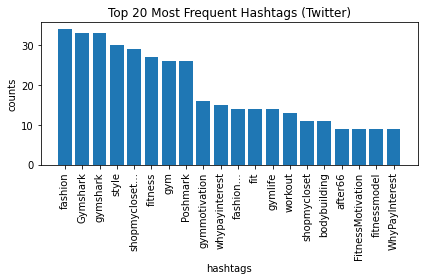

[('fashion', 34), ('Gymshark', 33), ('gymshark', 33), ('style', 30), ('shopmycloset…', 29), ('fitness', 27), ('gym', 26), ('Poshmark', 26), ('gymmotivation', 16), ('whypayinterest', 15), ('fashion…', 14), ('fit', 14), ('gymlife', 14), ('workout', 13), ('shopmycloset', 11), ('bodybuilding', 11), ('after66', 9), ('FitnessMotivation', 9), ('fitnessmodel', 9), ('WhyPayInterest', 9)]


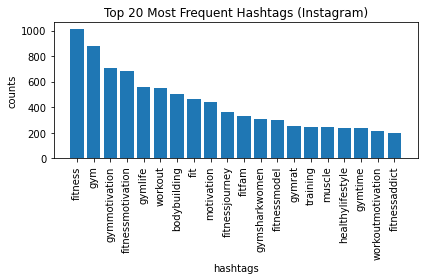

[('fitness', 1013), ('gym', 877), ('gymmotivation', 704), ('fitnessmotivation', 683), ('gymlife', 561), ('workout', 547), ('bodybuilding', 501), ('fit', 467), ('motivation', 445), ('fitnessjourney', 364), ('fitfam', 334), ('gymsharkwomen', 311), ('fitnessmodel', 298), ('gymrat', 250), ('training', 249), ('muscle', 247), ('healthylifestyle', 240), ('gymtime', 234), ('workoutmotivation', 217), ('fitnessaddict', 200)]


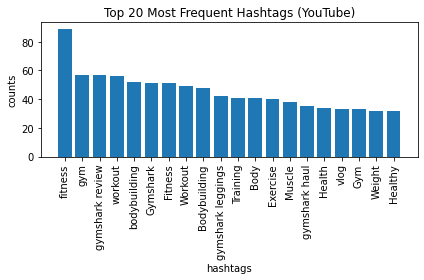

[('fitness', 89), ('gym', 57), ('gymshark review', 57), ('workout', 56), ('bodybuilding', 52), ('Gymshark', 51), ('Fitness', 51), ('Workout', 49), ('Bodybuilding', 48), ('gymshark leggings', 42), ('Training', 41), ('Body', 41), ('Exercise', 40), ('Muscle', 38), ('gymshark haul', 35), ('Health', 34), ('vlog', 33), ('Gym', 33), ('Weight', 32), ('Healthy', 32)]


In [18]:
get_most_freq_hashtag(df_lst[1:], title_lst[1:])

#### Sensitive Scores

In [14]:
# Function used to process captions by lemmatization and removing punctuations and most/least frequent words
# return the processed captions as pandas series
def processTextCalculateSentiment(df):
    # Remove all hashtags, punctuations, and stopwords
    captions = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    captions = captions.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x) for x in x.split()))
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in nltk.corpus.stopwords.words('english')))
    
    # Remove most 10 common words
    freq = pd.Series(' '.join(captions).split()).value_counts()[:10]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))
    # Remove 10 least frequent words
    least_freq = pd.Series(' '.join(captions).split()).value_counts()[-10:]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))

    # Lemmatization
    captions = captions.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    captions.replace('', np.nan, inplace=True)
    captions.dropna(inplace=True)
    
    df['fully_proccessed_tokens'] = captions
    df['sentiment_score'] = df['fully_proccessed_tokens'].apply(lambda x: sentiment_score(str(x)))
    return df

# Function used to compute sentimental score from the input
def sentiment_score(text):
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [15]:
def plotSentimentDistribution(df_list, title_list):
    for i in range(len(df_list)):
        df_list[i] = processTextCalculateSentiment(df_list[i])
        df_list[i]['sentiment_score'].hist()
        plt.xlabel('sentiment score')
        plt.ylabel('counts')
        plt.title('Sentiment Scores for ' + title_list[i])
        print('Average Sentiment Score for ' + title_list[i] + ' is ' + 
              str(df_list[i]['sentiment_score'].sum()/df_list[i].shape[0]))
        plt.show()

Average Sentiment Score for Reddit is 0.35006516613076105


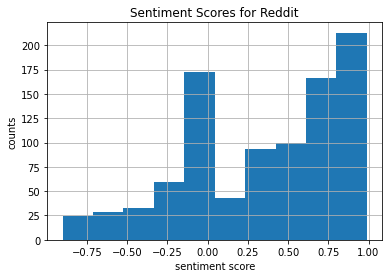

Average Sentiment Score for Twitter is 0.12334147126436781


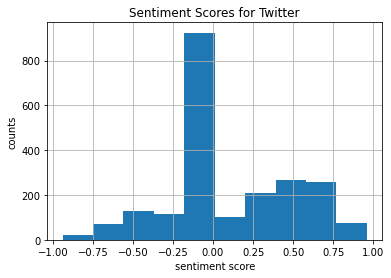

Average Sentiment Score for Instagram is 0.38068201009637453


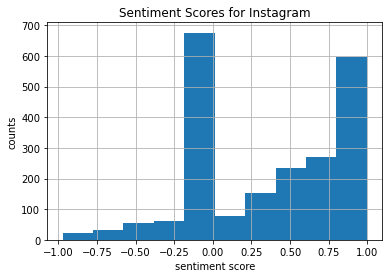

Average Sentiment Score for YouTube is 0.9677534626038781


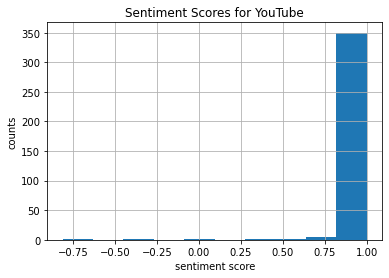

In [16]:
plotSentimentDistribution(df_lst, title_lst)

#### Word Frequency Distribution

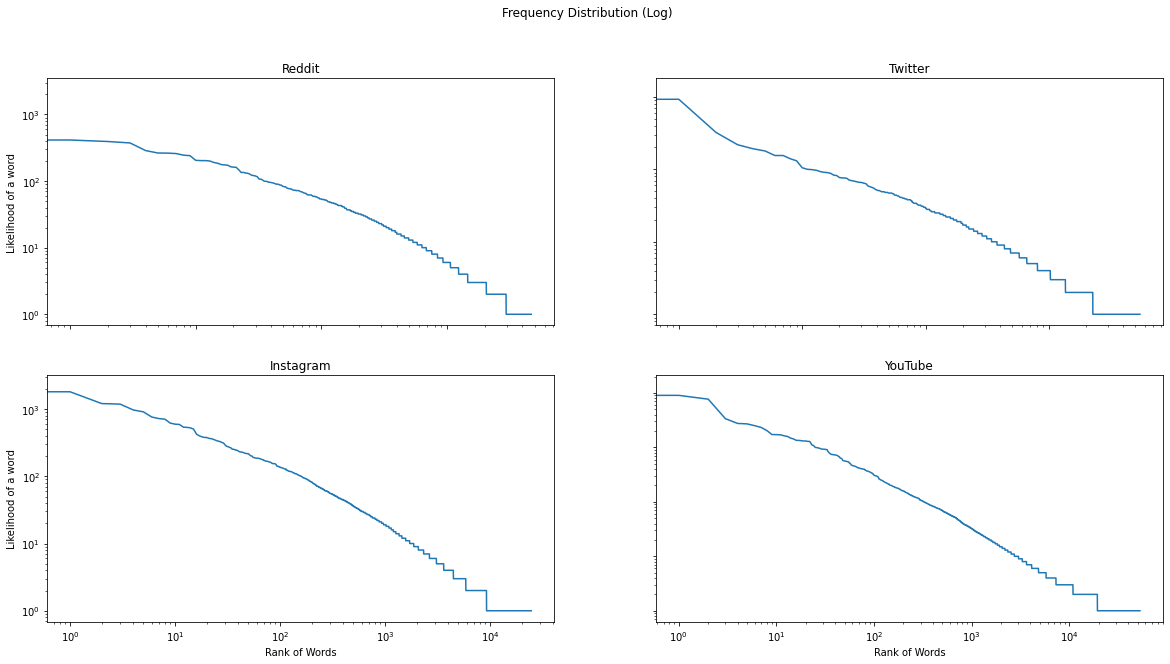

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Frequency Distribution (Log)")

axs[0, 0].plot(range(len(wordsCount_rdt)), wordsCount_rdt['count'])
axs[0, 0].set_title("Reddit")
axs[0, 1].plot(range(len(wordsCount_twt)), wordsCount_twt['count'])
axs[0, 1].set_title("Twitter")

axs[1, 0].plot(range(len(wordsCount_ins)), wordsCount_ins['count'])
axs[1, 0].set_title("Instagram")
axs[1, 1].plot(range(len(wordsCount_ytb)), wordsCount_ytb['count'])
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(xlabel='Rank of Words', ylabel='Likelihood of a word')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# set the spacing between subplots 
plt.show()

### Word Concordance

In [23]:
text = nltk.Text(token_twt) #Convert t_data into a Text class of nltk
CIndex = nltk.text.ConcordanceIndex(text) #Load the text into a ConcordanceIndex

In [24]:
# The surrounding words of 'enjoy'
CIndex.print_concordance('best')

Displaying 25 of 26 matches:
shark In all seriousness they are the best sports leggings I 've ever worn 🤩 🤩 🤩
remember these leggings they were the best leggings I lived and d I ’m not buyin
 the community to help you become the best version of you Join the Gymshark Fami
 the community to help you become the best version of you Join the Gymshark F @s
 Joanna Ducati HS2 will always be the best compliment @noodleboy456 @0kafor @Cor
the website They really do employ the best marketeers @Zieruhhh Me on gymshark t
g girl 😭 But Gymshark clothes are the best for real @Gymshark finding a code is 
 to be on my A game again What ’s the best 6 day split to do for muscle mass gym
d we @nunezeight you know it only the best for the best 😉 @itsmeekim best day ev
ght you know it only the best for the best 😉 @itsmeekim best day ever 🙌 @Gymshar
ly the best for the best 😉 @itsmeekim best day ever 🙌 @Gymshark bestie i did n’t
ten the @Gymshark training app is the best app I ’ve come across for gym workout

In [25]:
text.common_contexts(['fit'])

fitness_fitnessmotivation workout_motivation fitness_gym dri_and
n’t_just the_gymshark or_if gym_fitness gymshark#fitness_body
gym_everywhere gymshark_all gym_@buycapes 😈_friends new_😝
fitness_@gymshark n’t_into n't_anymore they_me joggers_from to_me


In [26]:
text.count('like')

99

In [17]:
# Make a plot to show each time a set of words occurs
list_of_words = ['love', 'hate', 'like', 'fit', 'worst', 'best', 'good']
token_lst = [token_rdt, token_twt, token_ins, token_ytb]
def plotWordsOccurance(token_list, title_list, df_list):
    for i in range(len(token_list)):
        text = nltk.Text(token_list[i])
        sns.reset_orig()
        nltk.draw.dispersion.dispersion_plot(text, list_of_words, 
                                             title="Word Occurances in {}".format(title_list[i]))
        sns.set()
                
        num_strong_pos = text.count('love') + text.count('best')
        num_strong_neg = text.count('hate') + text.count('worst')
        num_weak_pos = text.count('like') + text.count('good')
        total_words_count = df_list[i]['word_counts'].sum()
        print('Frequency Strong Positive Words: ' + str(num_strong_pos/total_words_count))
        print('Frequency Strong Negative Words: ' + str(num_strong_neg/total_words_count))
        print('Frequency Weak Positive Words: ' + str(num_weak_pos/total_words_count))
        print('Frequency Emotion Words: ' + str((num_weak_pos+num_strong_pos+num_strong_neg)/total_words_count))

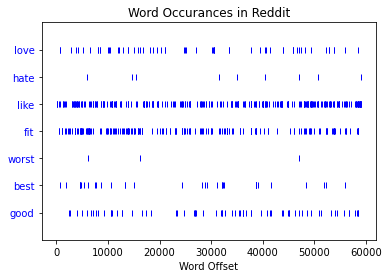

Frequency Strong Positive Words: 0.0016389564747228982
Frequency Strong Negative Words: 0.00020275750202757503
Frequency Weak Positive Words: 0.0056096242227629085
Frequency Emotion Words: 0.007451338199513382


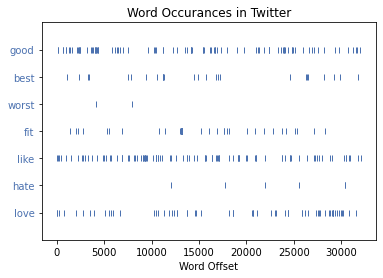

Frequency Strong Positive Words: 0.002955313068329436
Frequency Strong Negative Words: 0.0002598077422707197
Frequency Weak Positive Words: 0.006170433878929592
Frequency Emotion Words: 0.009385554689529748


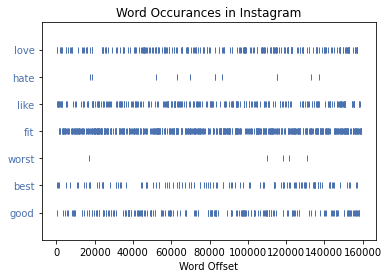

Frequency Strong Positive Words: 0.0024309092143681675
Frequency Strong Negative Words: 0.00011543423643647721
Frequency Weak Positive Words: 0.003075982888572011
Frequency Emotion Words: 0.005622326339376655


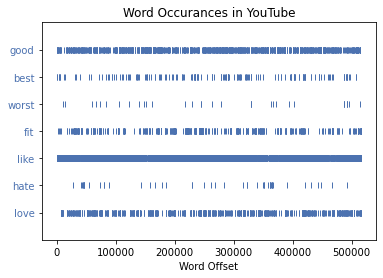

Frequency Strong Positive Words: 0.0014932281811473648
Frequency Strong Negative Words: 0.0001568761124162601
Frequency Weak Positive Words: 0.016830289097497536
Frequency Emotion Words: 0.01848039339106116


In [18]:
plotWordsOccurance(token_lst, title_lst, df_lst)

#### Word Distribution

#### (1) word frequency distribution (word lengths)

In [29]:
def wordDistributionLength(df_list, title_list, word_length, num_words=20):
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcfdist[word_length].plot(num_words, title=title_list[i])

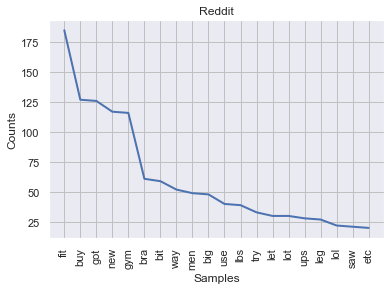

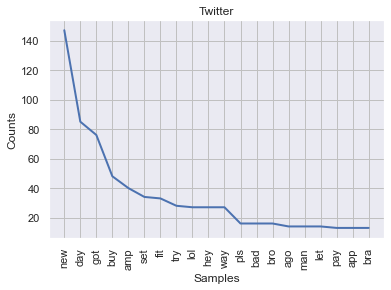

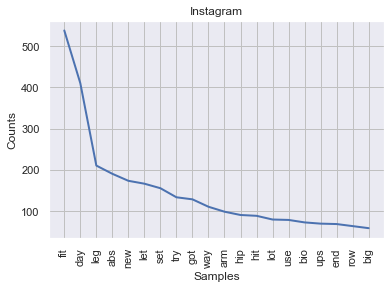

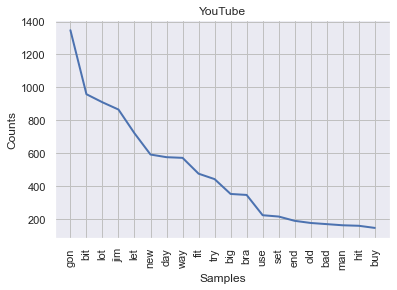

In [30]:
wordDistributionLength(df_lst, title_lst, 3)

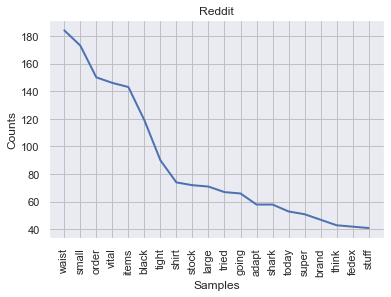

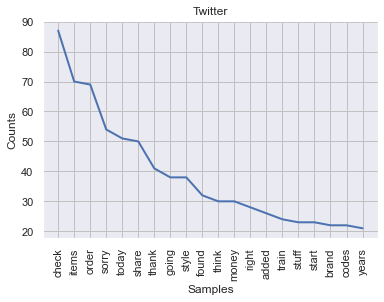

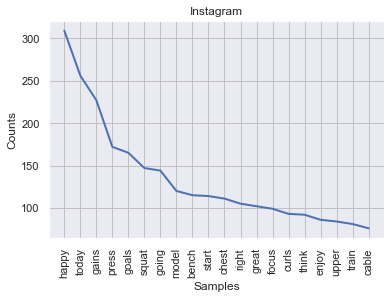

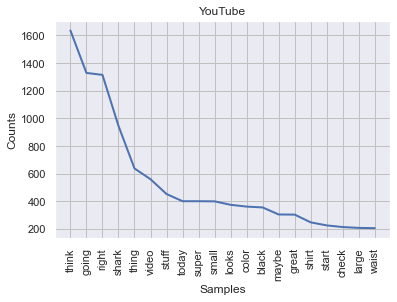

In [31]:
wordDistributionLength(df_lst, title_lst, 5)

#### (2) word frequency distribution (POS)

In [32]:
def wordDistributionPOS(df_list, title_list, pos, num_words=20):
    freqDict = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        POStoWord[pos].plot(num_words, title=title_list[i])
        freqDict[title_list[i]] = POStoWord[pos].most_common(10)
    return pd.DataFrame(freqDict)

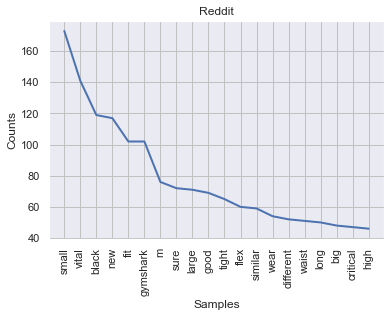

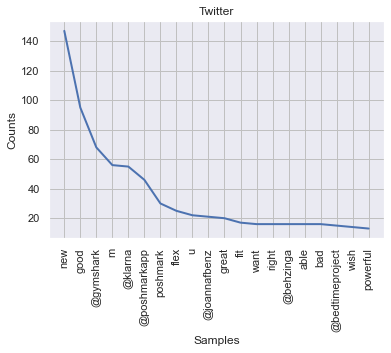

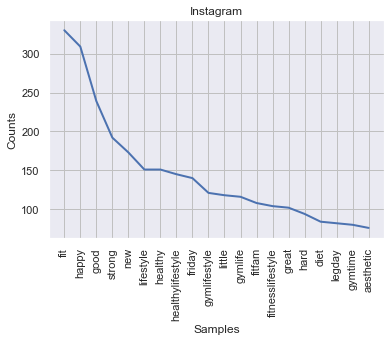

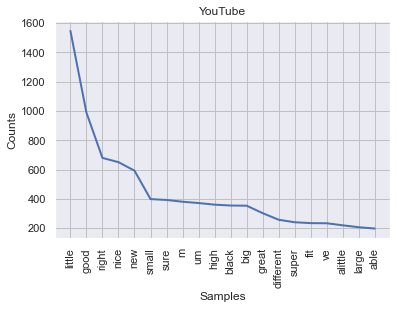

,Reddit,Twitter,Instagram,YouTube
0,"(small, 173)","(new, 147)","(fit, 330)","(little, 1547)"
1,"(vital, 141)","(good, 95)","(happy, 309)","(good, 989)"
2,"(black, 119)","(@gymshark, 68)","(good, 239)","(right, 680)"
3,"(new, 117)","(m, 56)","(strong, 192)","(nice, 651)"
4,"(fit, 102)","(@klarna, 55)","(new, 173)","(new, 593)"
5,"(gymshark, 102)","(@poshmarkapp, 46)","(lifestyle, 151)","(small, 399)"
6,"(m, 76)","(poshmark, 30)","(healthy, 151)","(sure, 393)"
7,"(sure, 72)","(flex, 25)","(healthylifestyle, 145)","(m, 381)"
8,"(large, 71)","(u, 22)","(friday, 140)","(um, 372)"
9,"(good, 69)","(@joannafbenz, 21)","(gymlifestyle, 121)","(high, 361)"


In [33]:
wordDistributionPOS(df_lst, title_lst, 'JJ')

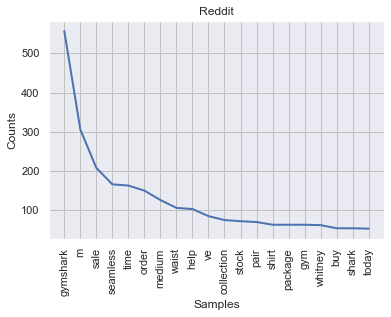

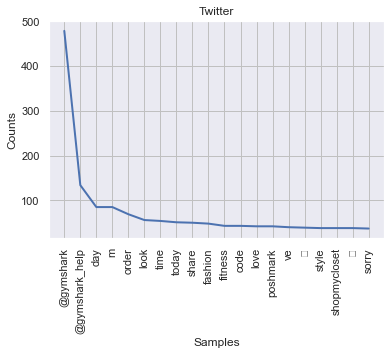

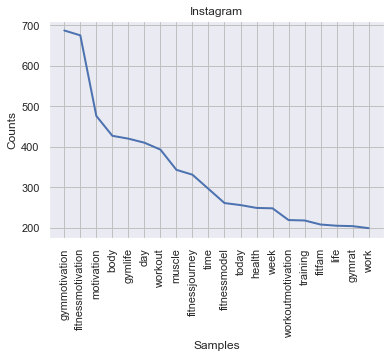

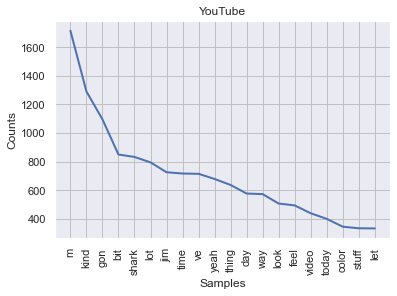

,Reddit,Twitter,Instagram,YouTube
0,"(gymshark, 557)","(@gymshark, 479)","(gymmotivation, 687)","(m, 1716)"
1,"(m, 306)","(@gymshark_help, 134)","(fitnessmotivation, 675)","(kind, 1291)"
2,"(sale, 208)","(day, 85)","(motivation, 476)","(gon, 1096)"
3,"(seamless, 166)","(m, 85)","(body, 427)","(bit, 850)"
4,"(time, 163)","(order, 69)","(gymlife, 420)","(shark, 833)"
5,"(order, 150)","(look, 56)","(day, 410)","(lot, 795)"
6,"(medium, 126)","(time, 54)","(workout, 393)","(jim, 726)"
7,"(waist, 106)","(today, 51)","(muscle, 343)","(time, 717)"
8,"(help, 103)","(share, 50)","(fitnessjourney, 331)","(ve, 715)"
9,"(ve, 85)","(fashion, 48)","(time, 296)","(yeah, 679)"


In [34]:
wordDistributionPOS(df_lst, title_lst, 'NN')

#### (3) conditional probability distribution (word length)

In [35]:
def wordProbDistribLength(df_list, title_list, word_length):
    most_common = {}
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)
        most_common_word = whcpdist[word_length].max()
        most_common[title_list[i]] = [most_common_word, whcpdist[word_length].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [36]:
wordProbDistribLength(df_lst, title_lst, 5)

,Reddit,Twitter,Instagram,YouTube
0,waist,check,happy,think
1,0.0397758,0.0358533,0.0296683,0.0439863


In [37]:
wordProbDistribLength(df_lst, title_lst, 6)

,Reddit,Twitter,Instagram,YouTube
0,shorts,loving,muscle,little
1,0.0636233,0.0288605,0.0335339,0.0496641


#### (4) conditional probability distribution (POS)

In [38]:
def wordProbDistribPOS(df_list, title_list, pos):
    most_common = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        whcpdist_POStoWord = nltk.ConditionalProbDist(POStoWord, nltk.ELEProbDist)
        most_common_word = whcpdist_POStoWord[pos].max()
        most_common[title_list[i]] = [most_common_word, whcpdist_POStoWord[pos].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [39]:
wordProbDistribPOS(df_lst, title_lst, 'JJ')

,Reddit,Twitter,Instagram,YouTube
0,small,new,fit,little
1,0.031191,0.0491339,0.0185805,0.0273176


In [40]:
wordProbDistribPOS(df_lst, title_lst, 'NN')

,Reddit,Twitter,Instagram,YouTube
0,gymshark,@gymshark,gymmotivation,m
1,0.0556027,0.0609508,0.0170306,0.0182521


#### (5) Word Cloud

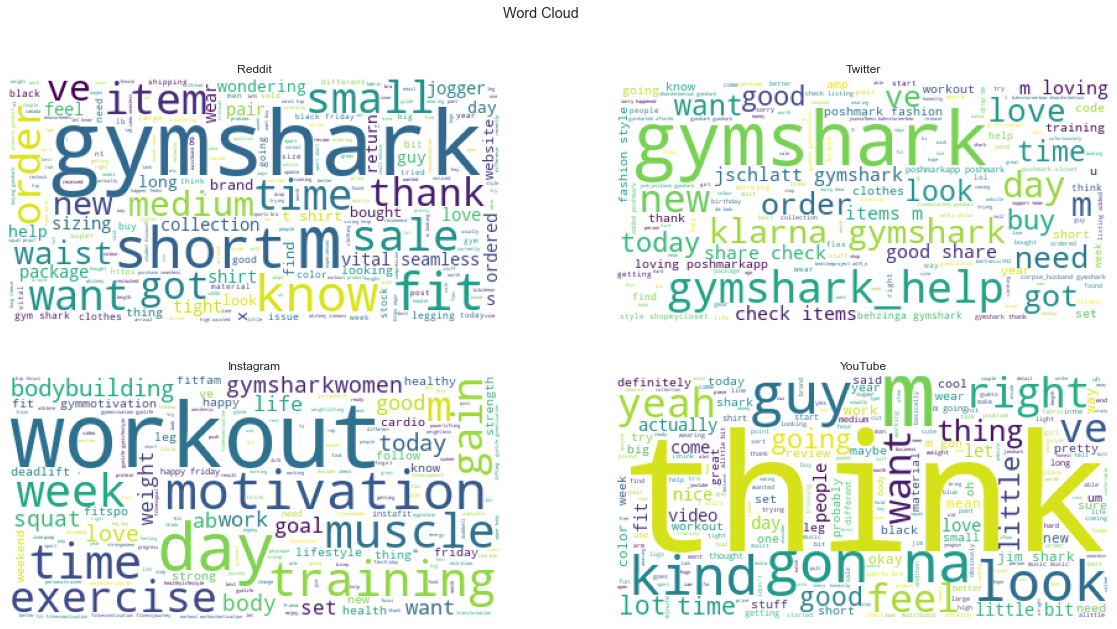

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Word Cloud")

wc_1 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(reddit['normalized_tokens'].sum()))
axs[0, 0].imshow(wc_1)
axs[0, 0].set_title("Reddit")
wc_2 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(twitter['normalized_tokens'].sum()))
axs[0, 1].imshow(wc_2)
axs[0, 1].set_title("Twitter")

wc_3 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(ins['normalized_tokens'].sum()))
axs[1, 0].imshow(wc_3)
axs[1, 0].set_title("Instagram")
wc_4 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(youtube['normalized_tokens'].sum()))
axs[1, 1].imshow(wc_4)
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

#### Bigrams

In [42]:
def bigrams(df_list, title_list):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_dict = {}
    for i in range(len(df_list)):
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        bigram_dict[title_list[i]] = bigrams.score_ngrams(bigram_measures.student_t)[:10]
    return pd.DataFrame(bigram_dict)

In [43]:
bigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((vital, seamless), 9.684507963504393)","((@klarna, @gymshark), 8.190511465291017)","((⁣, ⁣), 11.756987284694194)","((gon, na), 36.47970594661206)"
1,"((gym, shark), 7.3807774604311875)","((loving, @poshmarkapp), 6.83104777868984)","((happy, friday), 11.17671024123865)","((little, bit), 22.746755364850106)"
2,"((whitney, simmons), 6.53695613003587)","((share, check), 6.815833292944295)","((fitnessmotivation, fitnessjourney), 10.88823...","((jim, shark), 21.34680495206244)"
3,"((black, friday), 6.441309360538819)","((good, share), 6.811713847345321)","((gymmotivation, gymlife), 10.696284958586492)","((m, gon), 18.873436093451325)"
4,"((feel, like), 6.265853281332729)","((check, items), 6.7999047699615955)","((💪, 🏼), 10.556746894115435)","((m, going), 13.969963230981598)"
5,"((t, shirt), 6.05331295378108)","((m, loving), 6.7761218373701855)","((❤, ️), 10.515709101348039)","((sports, bra), 12.722755058988293)"
6,"((high, waisted), 5.817974998936891)","((poshmark, fashion), 6.750350605663781)","((♀, ️), 10.008821797854582)","((alittle, bit), 11.515267521772305)"
7,"((sports, bra), 5.631592547759376)","((items, m), 6.739669320981042)","((🔥, 🔥), 9.780237905305338)","((t, shirt), 9.465340363571558)"
8,"((waist, hips), 5.463249392448676)","((@jschlatt, @gymshark), 6.417305853874497)","((💪, 🏻), 9.67165199612783)","((m, sure), 7.9513805777640325)"
9,"((m, sure), 5.4521948326777165)","((fashion, style), 5.724635594670124)","((.⁣, .⁣), 8.532997255493461)","((high, waisted), 7.7899496120348735)"


#### Trigrams

In [44]:
def trigrams(df_list, title_list):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_dict = {}
    for i in range(len(df_list)):
        trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        trigram_dict[title_list[i]] = trigrams.score_ngrams(trigram_measures.student_t)[:10]
    return pd.DataFrame(trigram_dict)

In [45]:
trigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((black, friday, sale), 4.242151528458867)","((share, check, items), 6.855479660554052)","((.⁣, .⁣, .⁣), 7.280096827582177)","((m, gon, na), 19.71794838009728)"
1,"((high, waisted, flex), 3.464040209441529)","((good, share, check), 6.8554146828965985)","((⁣, ⁣, ⁣), 6.854863395644146)","((gon, na, try), 6.478238711287166)"
2,"((whitney, simmons, x), 3.162241176866472)","((m, loving, @poshmarkapp), 6.855375082720003)","((🔥, 🔥, 🔥), 6.081573818584967)","((gon, na, look), 3.596222713537179)"
3,"((whitney, simmons, collection), 2.99986889735...","((items, m, loving), 6.855305203299741)","((➖, ➖, ➖), 5.6568531027534945)","((gon, na, lie), 3.4638485995001393)"
4,"((waist, inch, hips), 2.8281299084716878)","((check, items, m), 6.855021318154933)","((gymmotivation, gymrat, gymlife), 5.565621160...","((jim, shark, logo), 3.463084044880856)"
5,"((adapt, animal, seamless), 2.645614460720617)","((poshmark, fashion, style), 5.744472603376582)","((°, °, °), 5.477224193687815)","((gon, na, start), 3.4617295935351136)"
6,"((simmons, x, gymshark), 2.6453730300017844)","((fashion, style, shopmycloset), 5.47717310946...","((gymgirls, healthylifestyle, fitgorgeousgirls...","((m, going, try), 3.4546014348934984)"
7,"((gymshark, vital, seamless), 2.634366890495792)","((@poshmarkapp, poshmark, fashion), 5.47708640...","((fashionmodel, gymmotivation, gymgirls), 5.47...","((gon, na, come), 3.312121253613272)"
8,"((png&auto, =, webp&s), 2.44948902583153)","((loving, @poshmarkapp, poshmark), 5.477086403...","((🏼‍, ♀, ️), 5.477141943874151)","((today, m, going), 3.307685497879309)"
9,"((=, png&auto, =), 2.4494859190410536)","((listing, added, poshmark), 5.098981917484419)","((gymmotivation, gymgirls, healthylifestyle), ...","((element, t, shirt), 3.1622698498256123)"


#### KL Divergence

In [22]:
rdt_words = set(reddit['normalized_tokens'].sum())
twt_words = set(twitter['normalized_tokens'].sum())
ins_words = set(ins['normalized_tokens'].sum())
ytb_words = set(youtube['normalized_tokens'].sum())

overlapWords = rdt_words & twt_words & ins_words & ytb_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [23]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

rdtProbArray = makeProbsArray(reddit['normalized_tokens'], overlapWordsDict)
twtProbArray = makeProbsArray(twitter['normalized_tokens'], overlapWordsDict)
insProbArray = makeProbsArray(ins['normalized_tokens'], overlapWordsDict)
ytbProbArray = makeProbsArray(youtube['normalized_tokens'], overlapWordsDict)

In [24]:
# Calculate divergences
rdt_twt_divergence = scipy.stats.entropy(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_divergence))
rdt_ins_divergence = scipy.stats.entropy(rdtProbArray, insProbArray)
print("Reddit & Instagra: {}".format(rdt_ins_divergence))
rdt_ytb_divergence = scipy.stats.entropy(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}".format(rdt_ytb_divergence))

twt_ins_divergence = scipy.stats.entropy(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_divergence))
twt_ytb_divergence = scipy.stats.entropy(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_divergence))
ins_ytb_divergence = scipy.stats.entropy(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}".format(ins_ytb_divergence))

Reddit & Twitter: 0.653750677629477
Reddit & Instagra: 1.2425686831721106
Reddit & YouTube: 0.7431412708798025
Twitter & Instagram: 0.7445319106391315
Twitter & YouTube: 0.7785615982540091
Instagram & YouTube: 0.9565831294282687


In [49]:
from IPython.display import display

# Elementwise calculation and see which words best distinguish the two corpora
def wordMostDistinguish(probArray_list, title_list, num_words=10):
    kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
    kl_df = kl_df.sort_index()
    for i in range(len(probArray_list)):
        print(title_list[i])
        result = {}
        for j in range(len(probArray_list)):
            if (probArray_list[j] != probArray_list[i]).all():
                divergence_ew = scipy.special.kl_div(probArray_list[j], probArray_list[i])
                wd_df = kl_df
                wd_df['elementwise divergence'] = divergence_ew
                wd_df = wd_df.sort_values(by='elementwise divergence', ascending=False)[:num_words]
                wd_df[" vs. " + title_list[j]] = wd_df['word'] + ", " + wd_df['elementwise divergence'].astype(str)
                wd_df.drop(columns=['word', 'elementwise divergence'], inplace=True)
                wd_df.reset_index(drop=True, inplace=True)
                result.update(wd_df.to_dict())
        display(pd.DataFrame.from_dict(result))

In [50]:
probArray_lst = [rdtProbArray, twtProbArray, insProbArray, ytbProbArray]
wordMostDistinguish(probArray_lst, title_lst)

Reddit


,vs. Twitter,vs. Instagram,vs. YouTube
0,"😂, 0.030235945733314243","💪, 0.08616170813308954","yeah, 0.06056497168699757"
1,"💪, 0.028687790293212972","motivation, 0.07452584827434947","gon, 0.02790323249776446"
2,"check, 0.01740919063455515","workout, 0.07437906682628914","na, 0.02790323249776446"
3,"day, 0.015660922316148514","muscle, 0.027224619082332244","little, 0.02145332977908465"
4,"u, 0.015517229652456197","gains, 0.02416061735349778","think, 0.01803344750147485"
5,"sorry, 0.014005944736860083","happy, 0.021932023853971812","kind, 0.01742939651096522"
6,"share, 0.011620678746538583","health, 0.02154745500210296","right, 0.014686927560709552"
7,"train, 0.009826178443810382","body, 0.021239526987588093","video, 0.010981946688055669"
8,"waist, 0.009217706681077216","day, 0.020884622539175404","nice, 0.010809154497729177"
9,"seamless, 0.008063266303153578","press, 0.020697001471940174","sale, 0.009487568212461314"


Twitter


,vs. Reddit,vs. Instagram,vs. YouTube
0,"waist, 0.023839393250894167","workout, 0.02917225252145915","little, 0.030675892350013986"
1,"vital, 0.022943881911235562","muscle, 0.026085197948879913","kind, 0.022261440609459636"
2,"wondering, 0.01929290376374706","friday, 0.024052577723376278","bit, 0.02032987377164121"
3,"seamless, 0.0167966591965605","motivation, 0.01949910020437894","guys, 0.019533099512009287"
4,"xs, 0.015744251997531943","health, 0.015174051044883272","gon, 0.01849906952102088"
5,"sale, 0.015361908055855347","body, 0.014904112080739823","na, 0.01849906952102088"
6,"medium, 0.014883924644836753","follow, 0.014437511860169196","yeah, 0.015252769331160087"
7,"hips, 0.013237399219577293","x, 0.013664149545809499","😂, 0.011972254844591421"
8,"large, 0.01103886629751506","squats, 0.01351705166702318","think, 0.011937048403276614"
9,"😂, 0.010389485351491309","fit, 0.011702865927294482","lot, 0.010714732328435651"


Instagram


,vs. Reddit,vs. Twitter,vs. YouTube
0,"waist, 0.03688287829627385","items, 0.029293761572433342","shark, 0.040536794799167705"
1,"sale, 0.0321804594566746","workout, 0.01686521339870104","yeah, 0.037515863401535975"
2,"workout, 0.027796559092379394","check, 0.016777641387313965","gon, 0.027811191943338965"
3,"items, 0.026462668674262172","sorry, 0.016502877929324058","na, 0.026726042823183947"
4,"medium, 0.02534706468667512","order, 0.015309552935085045","kind, 0.02557292308542464"
5,"wondering, 0.023904721969573817","buy, 0.013269335025420253","workout, 0.021146675652041622"
6,"seamless, 0.0219041771551996","new, 0.010584588069165908","💪, 0.01827195929130933"
7,"vital, 0.021085127308655756","motivation, 0.009984819030549867","guys, 0.017842361996127515"
8,"shorts, 0.019533307720677212","muscle, 0.009915476883859964","think, 0.01578210891546971"
9,"ordered, 0.01893020605717483","clothes, 0.009735247225692457","motivation, 0.014973766420109483"


YouTube


,vs. Reddit,vs. Twitter,vs. Instagram
0,"xs, 0.026244343427647004","😂, 0.07269558705415523","💪, 0.11841913001922068"
1,"sale, 0.02173518388832519","💪, 0.04189665816140504","motivation, 0.05160438323570592"
2,"wondering, 0.01826936518662044","u, 0.01620778065809234","workout, 0.04198201159081252"
3,"gs, 0.018103004394545666","lol, 0.015386906745169574","x, 0.02752005861774735"
4,"shorts, 0.015133577544144024","items, 0.014338598559411156","health, 0.023646313309905152"
5,"vital, 0.014186892596236626","little, 0.01289067974149165","muscle, 0.021862122019662773"
6,"s, 0.01376683856852642","£, 0.012606816057892547","gains, 0.020457584946380603"
7,"yeah, 0.013353787993832173","code, 0.010140310648184998","😂, 0.018495934873841016"
8,"items, 0.012662879311892791","check, 0.010087961206936358","training, 0.016758096999175544"
9,"hips, 0.012468250392560025","order, 0.009938241958459904","friday, 0.015431058551020256"


In [27]:
# Functions to calculate divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Distance

           Reddit  Twitter  Instagram  YouTube
Reddit        0.0      NaN        NaN      NaN
Twitter       NaN      0.0        NaN      NaN
Instagram     NaN      NaN        0.0      NaN
YouTube       NaN      NaN        NaN      0.0


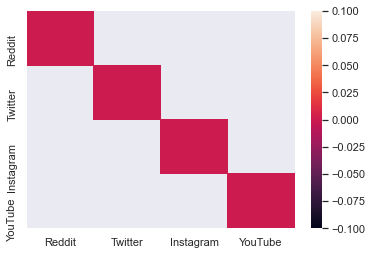

In [29]:
# Plot KL distances heatmap
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Distance

           Reddit  Twitter  Instagram  YouTube
Reddit        0.0   2175.0     2179.0    361.0
Twitter     933.0      0.0     2179.0    361.0
Instagram   933.0   2175.0        0.0    361.0
YouTube     933.0   2175.0     2179.0      0.0


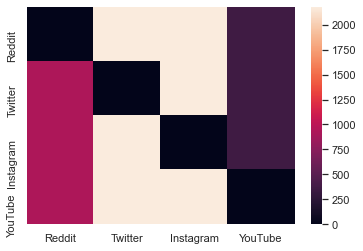

In [26]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.256141   0.210623  0.261765
Twitter    0.256141  0.000000   0.045519  0.005623
Instagram  0.210623  0.045519   0.000000  0.051142
YouTube    0.261765  0.005623   0.051142  0.000000


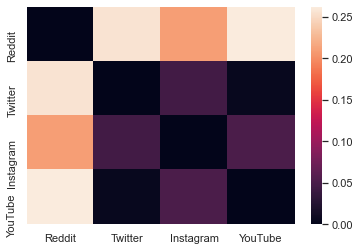

In [32]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

In [35]:
M2 = [[0.,0.20784015,0.21744878,0.22369878], 
      [0.20784015, 0. ,0.01292054, 0.03126416], 
      [0.21744878, 0.01292054, 0., 0.01875],
      [0.22369878,0.03126416,0.01875,0.]]

In [36]:
M2

[[0.0, 0.20784015, 0.21744878, 0.22369878],
 [0.20784015, 0.0, 0.01292054, 0.03126416],
 [0.21744878, 0.01292054, 0.0, 0.01875],
 [0.22369878, 0.03126416, 0.01875, 0.0]]

#### Wasserstein Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.377213   0.333826  0.372059
Twitter    0.377213  0.000000   0.076772  0.019213
Instagram  0.333826  0.076772   0.000000  0.081927
YouTube    0.372059  0.019213   0.081927  0.000000


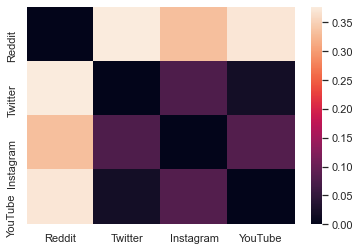

In [31]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

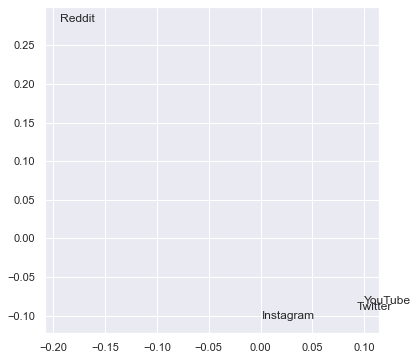

In [52]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(title_lst):
    ax.annotate(txt, (x[i],y[i]))

#### Jensen-Shannon Divergence

In [57]:
# Calculate Jensen-Shannon Divergences
rdt_twt_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_JSD))
rdt_ins_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, insProbArray)
print("Reddit & Instagram: {}".format(rdt_ins_JSD))
rdt_ytb_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}\n".format(rdt_ytb_JSD))

twt_ins_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_JSD))
twt_ytb_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_JSD))
ins_ytb_JSD = scipy.spatial.distance.jensenshannon(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}\n".format(ins_ytb_JSD))

Reddit & Twitter: 0.37173533798036495
Reddit & Instagram: 0.48261279898427384
Reddit & YouTube: 0.385325251235437

Twitter & Instagram: 0.3937207347404863
Twitter & YouTube: 0.3783266651888068
Instagram & YouTube: 0.41562257280421583



## Discovering Patterns: Clusters & Topics 

#### Selecting Cluster Number

In [58]:
def getTFVects(df):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    return TFVectorizer, TFVects

In [59]:
from sklearn.cluster import KMeans
def plotSilhouette_revised(n_clusters, X, reduced_data):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

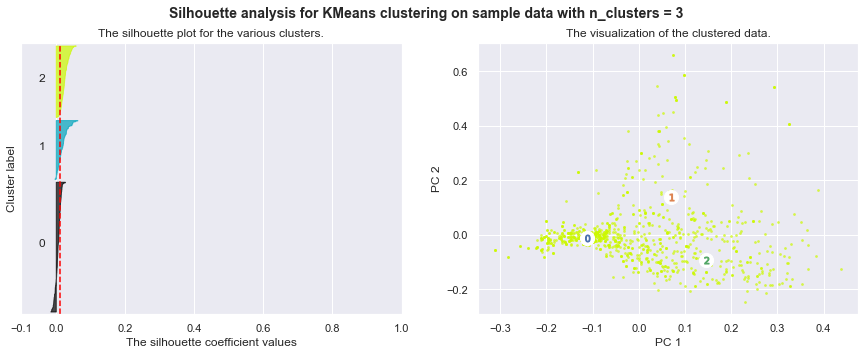

For n_clusters = 3, The average silhouette_score is : 0.014


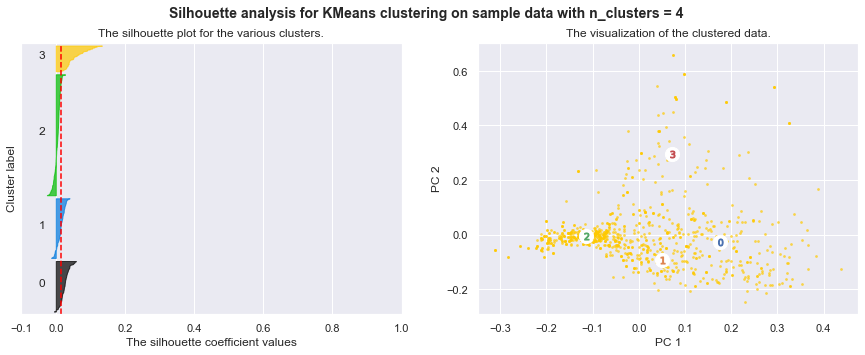

For n_clusters = 4, The average silhouette_score is : 0.015


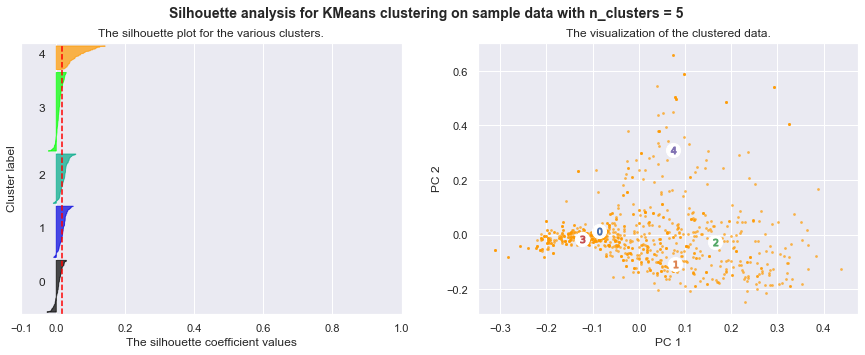

For n_clusters = 5, The average silhouette_score is : 0.018


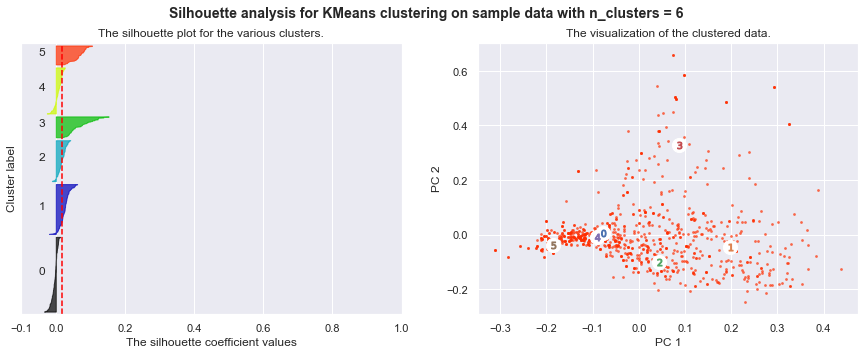

For n_clusters = 6, The average silhouette_score is : 0.019


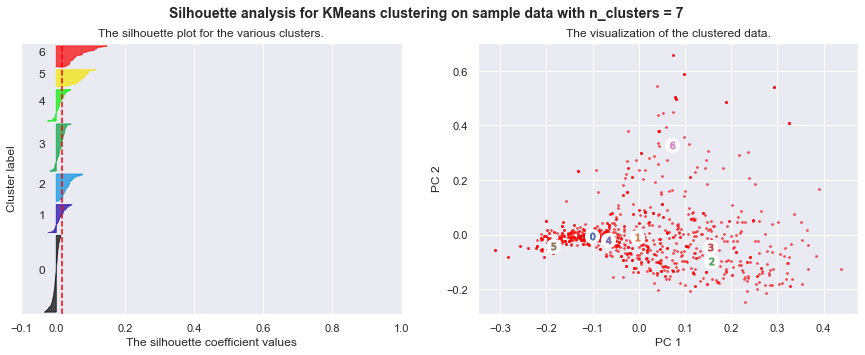

For n_clusters = 7, The average silhouette_score is : 0.018


In [60]:
cluster_num = [3, 4, 5, 6, 7]
rdtTFVectorizer, rdtTFVects = getTFVects(reddit)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(rdtTFVects.toarray())
    reduced_data = pca.transform(rdtTFVects.toarray())
    X = rdtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

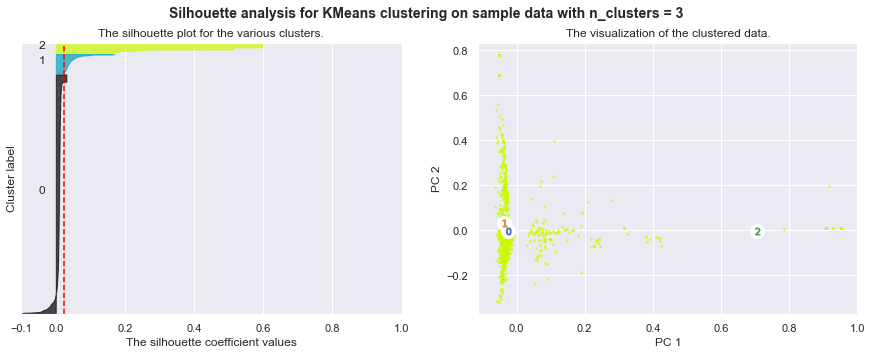

For n_clusters = 3, The average silhouette_score is : 0.025


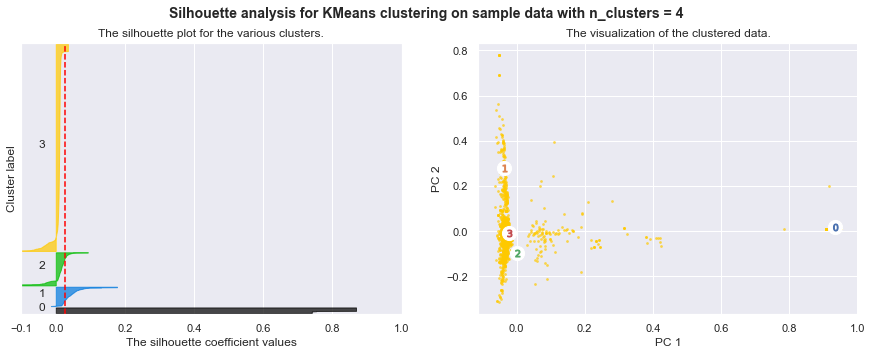

For n_clusters = 4, The average silhouette_score is : 0.028


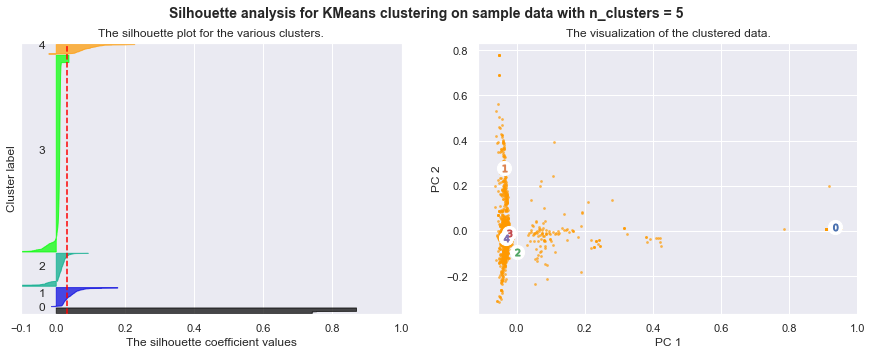

For n_clusters = 5, The average silhouette_score is : 0.031


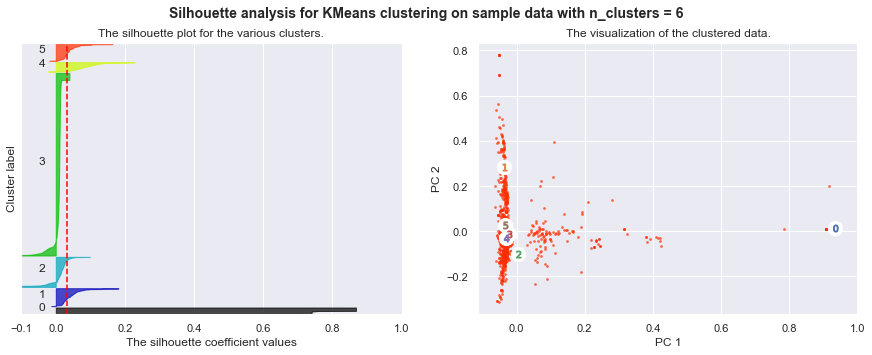

For n_clusters = 6, The average silhouette_score is : 0.033


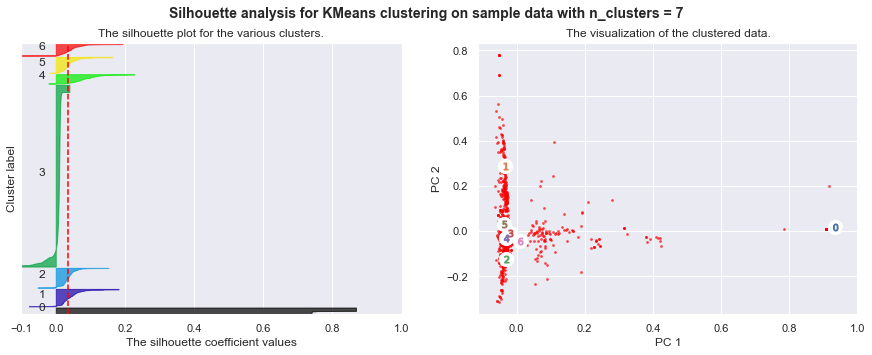

For n_clusters = 7, The average silhouette_score is : 0.036


In [61]:
twtTFVectorizer, twtTFVects = getTFVects(twitter)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(twtTFVects.toarray())
    reduced_data = pca.transform(twtTFVects.toarray())
    X = twtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

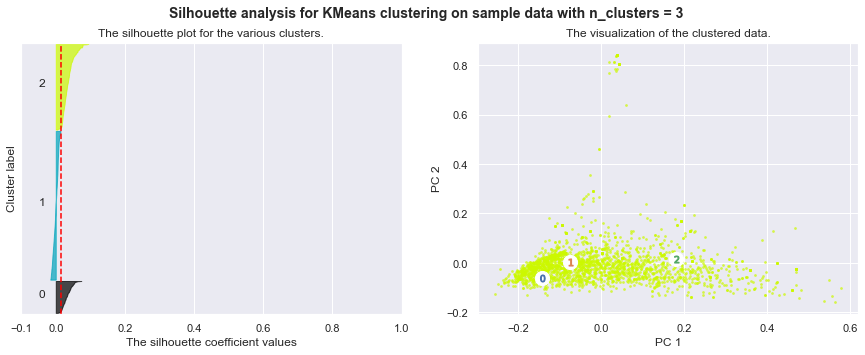

For n_clusters = 3, The average silhouette_score is : 0.015


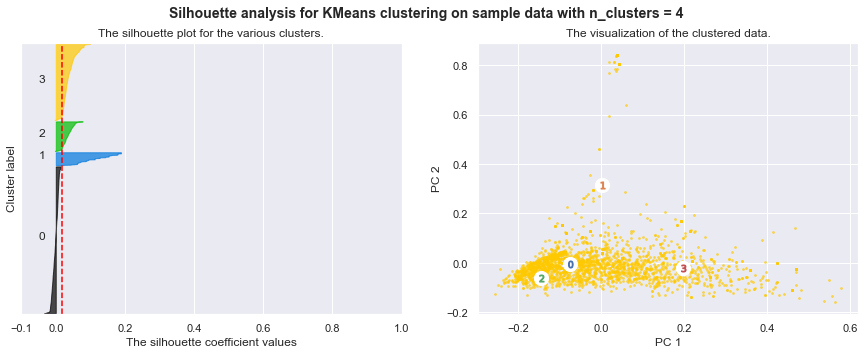

For n_clusters = 4, The average silhouette_score is : 0.019


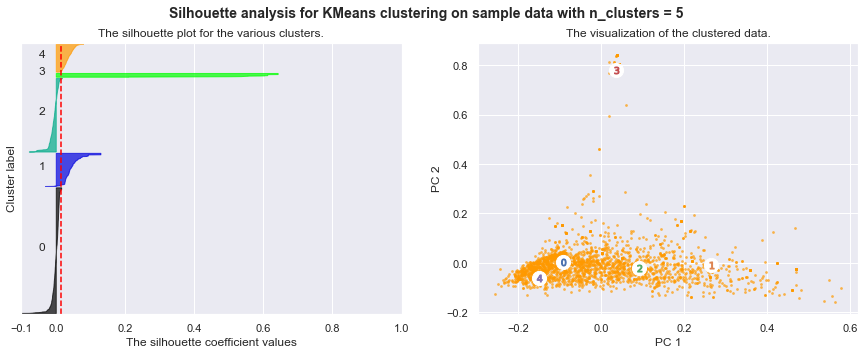

For n_clusters = 5, The average silhouette_score is : 0.015


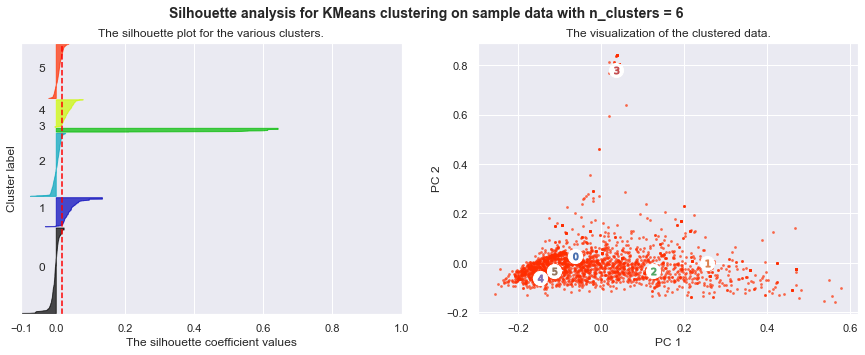

For n_clusters = 6, The average silhouette_score is : 0.017


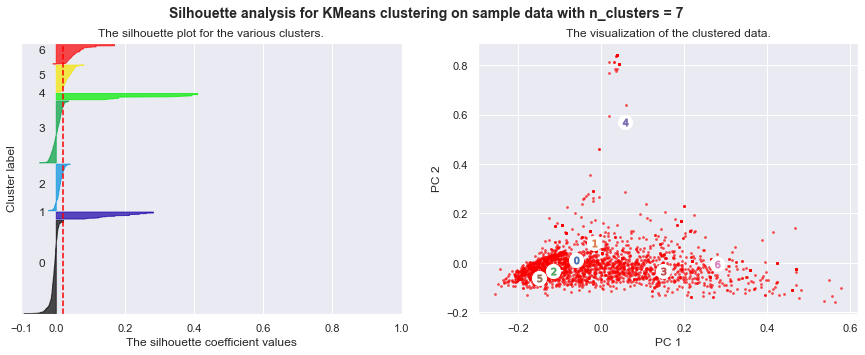

For n_clusters = 7, The average silhouette_score is : 0.020


In [62]:
insTFVectorizer, insTFVects = getTFVects(ins)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(insTFVects.toarray())
    reduced_data = pca.transform(insTFVects.toarray())
    X = insTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

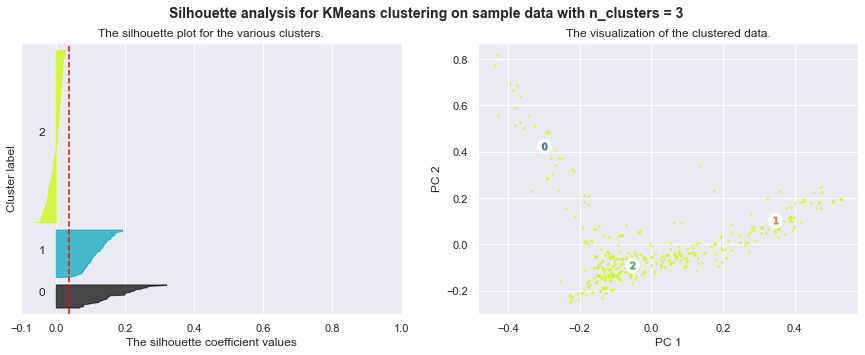

For n_clusters = 3, The average silhouette_score is : 0.039


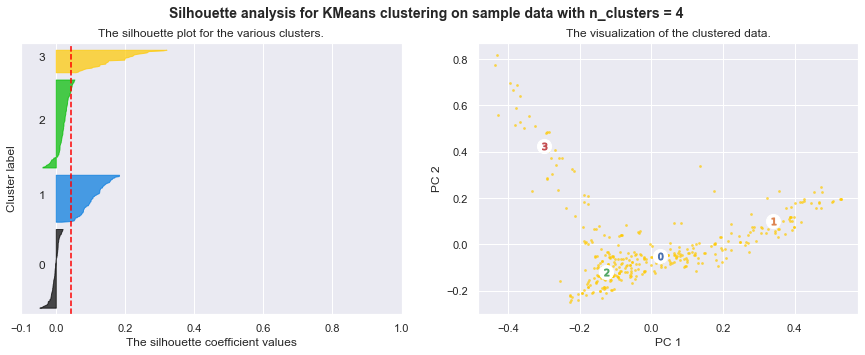

For n_clusters = 4, The average silhouette_score is : 0.044


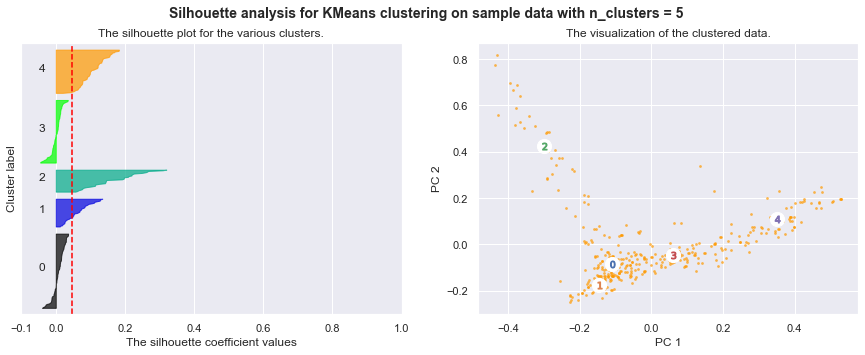

For n_clusters = 5, The average silhouette_score is : 0.046


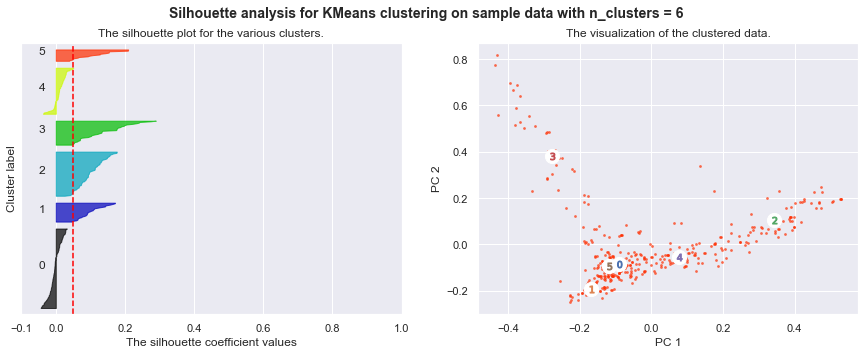

For n_clusters = 6, The average silhouette_score is : 0.050


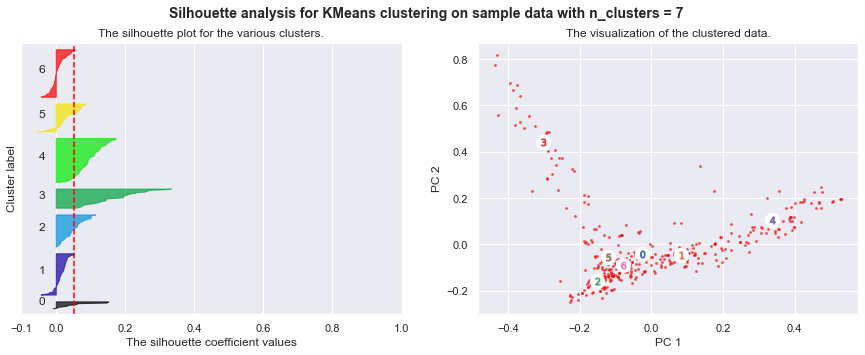

For n_clusters = 7, The average silhouette_score is : 0.051


In [63]:
ytbTFVectorizer, ytbTFVects = getTFVects(youtube)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(ytbTFVects.toarray())
    reduced_data = pca.transform(ytbTFVects.toarray())
    X = ytbTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

#### Flat Clustering with $K$-means

In [64]:
colordict = {0: 'plum', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'red', 6: 'purple'}
def kMeanClustering(df, n):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    km = sklearn.cluster.KMeans(n_clusters=n, init='k-means++')
    km.fit(TFVects.toarray())
    
    print("Evaluations")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['text'], km.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['text'], km.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['text'], km.labels_)))
    print("Adjusted Rand Score: {:0.3f}\n".format(sklearn.metrics.adjusted_rand_score(df['text'], km.labels_)))
    
    # Distinguish features of the clusters
    print("Top terms per cluster:")
    terms = TFVectorizer.get_feature_names()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(n):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')
    
    df['kmeans_predictions'] = km.labels_
    colors = [colordict[c] for c in df['kmeans_predictions']]
    
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    components = pca.components_
    keyword_ids = list(set(order_centroids[:,:5].flatten()))
    words = [terms[i] for i in keyword_ids]
    x = components[:,keyword_ids][0,:]
    y = components[:,keyword_ids][1,:]
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))   
    plt.xticks(())
    plt.yticks(())
    plt.title('True Classes')
    plt.show()
    return df

Evaluations
Homogeneity: 0.249
Completeness: 1.000
V-measure: 0.399
Adjusted Rand Score: 0.005

Top terms per cluster:
Cluster 0:
 gym
 shark
 arrived
 time
 heads
 brand
 long
 logo
 leggings
 https


Cluster 1:
 sale
 gymshark
 just
 blackout
 going
 website
 summer
 buy
 code
 black


Cluster 2:
 shorts
 arrival
 sport
 inseam
 men
 small
 looking
 medium
 gymshark
 bought


Cluster 3:
 gymshark
 like
 know
 order
 items
 package
 shipping
 just
 sold
 fedex


Cluster 4:
 leggings
 seamless
 vital
 gymshark
 pair
 xs
 adapt
 want
 black
 just


Cluster 5:
 size
 sizing
 small
 medium
 waist
 wear
 leggings
 help
 gymshark
 large




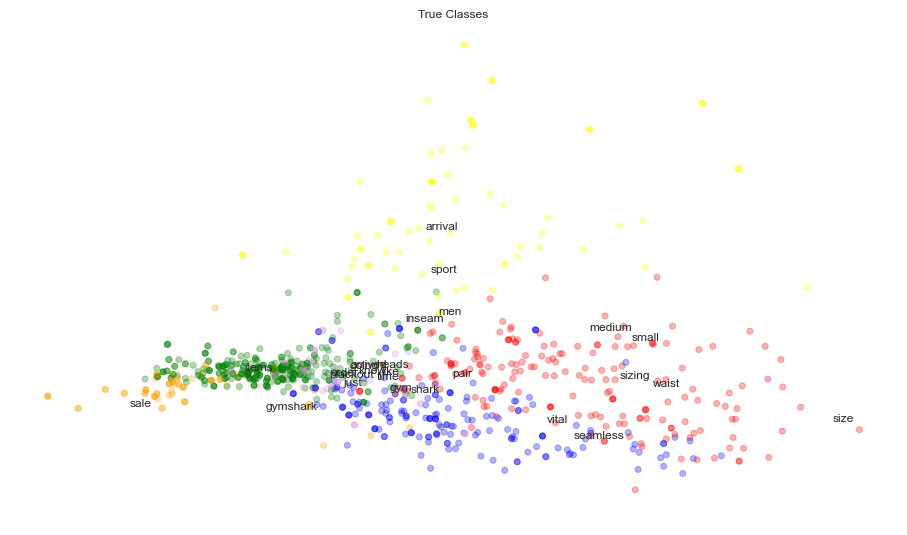

In [65]:
reddit = kMeanClustering(reddit, 6)

Evaluations
Homogeneity: 0.115
Completeness: 1.000
V-measure: 0.206
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 gym
 new
 just
 klarna
 like
 love
 day
 don
 look
 want


Cluster 1:
 loving
 share
 fashion
 poshmarkapp
 items
 poshmark
 check
 good
 style
 shopmycloset


Cluster 2:
 rt
 corpse_husband
 gym
 jschlatt
 gymmotivation
 training
 love
 fitness
 like
 new


Cluster 3:
 gymshark_help
 gymsharkcentral
 dm
 support
 help
 new
 order
 fix
 set
 hi


Cluster 4:
 leggings
 just
 flex
 camo
 added
 listing
 closet
 pair
 high
 poshmark


Cluster 5:
 thank
 corpse_husband
 gymshark_help
 rt
 ve
 love
 dm
 appreciate
 customer
 oh




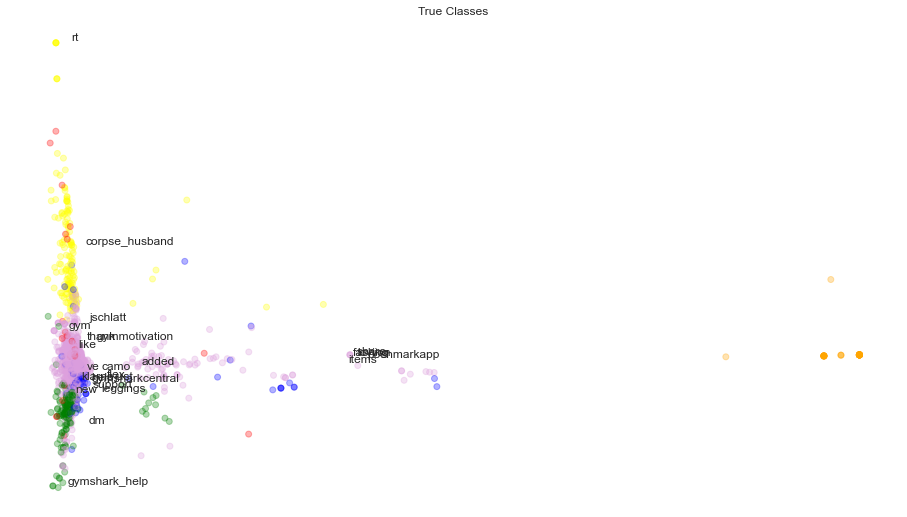

In [66]:
twitter = kMeanClustering(twitter, 6)

Evaluations
Homogeneity: 0.186
Completeness: 1.000
V-measure: 0.313
Adjusted Rand Score: 0.001

Top terms per cluster:
Cluster 0:
 leg
 10
 12
 press
 reps
 4x10
 workout
 squats
 sets
 db


Cluster 1:
 fitness
 gym
 bodybuilding
 workout
 fitnessmotivation
 gymmotivation
 motivation
 fit
 gymlife
 fitfam


Cluster 2:
 friday
 day
 gymsharkwomen
 just
 happy
 don
 gym
 like
 week
 time


Cluster 3:
 beauty
 fitgirl
 follow
 fitgorgeousgirlss
 fashionmodel
 fashionnova
 gymgirls
 fit
 instagram
 beautiful


Cluster 4:
 com
 yogainspiration
 playerlayer
 custom
 rabattcode
 wear
 available
 logo
 printing
 tshirts


Cluster 5:
 gymmotivation
 gymlife
 gymtime
 gymnastics
 gym
 fitnessmodel
 fitnessmotivation
 gymlifestyle
 gymrat
 fitness




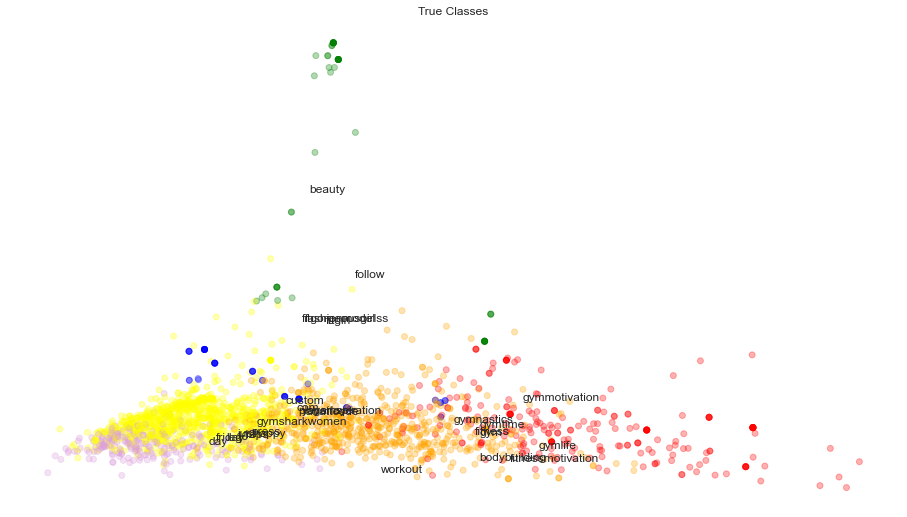

In [67]:
ins = kMeanClustering(ins, 6)

Evaluations
Homogeneity: 0.307
Completeness: 1.000
V-measure: 0.470
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 music
 applause
 routine
 weight
 hands
 workout
 wall
 walk
 night
 okay


Cluster 1:
 workout
 sets
 reps
 work
 week
 10
 stuff
 body
 chest
 trying


Cluster 2:
 leggings
 bra
 sports
 seamless
 definitely
 size
 waistband
 fabric
 super
 high


Cluster 3:
 __
 expo
 man
 booth
 germany
 year
 car
 chris
 family
 everybody


Cluster 4:
 business
 market
 ben
 ultimately
 growth
 billion
 company
 francis
 brand
 sort


Cluster 5:
 fit
 shirt
 black
 size
 large
 medium
 pants
 color
 cool
 wear


Cluster 6:
 things
 uh
 said
 wanted
 um
 okay
 years
 stuff
 life
 need




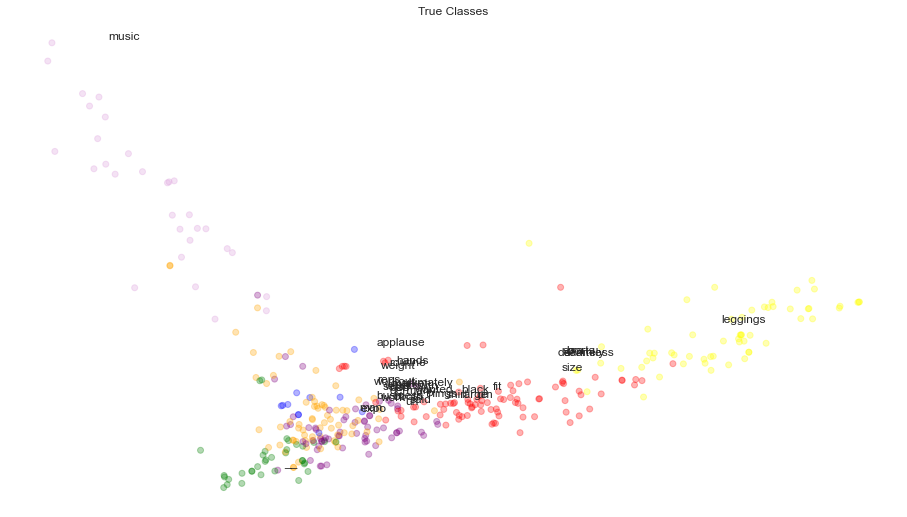

In [68]:
youtube = kMeanClustering(youtube, 7)

#### Hierarchical Cluster

In [69]:
def getLinkageMatrix(TFVects):
    CoocMat = TFVects * TFVects.T
    CoocMat.setdiag(0)
    matrix = scipy.cluster.hierarchy.ward(CoocMat[:50, :50].toarray())
    return matrix

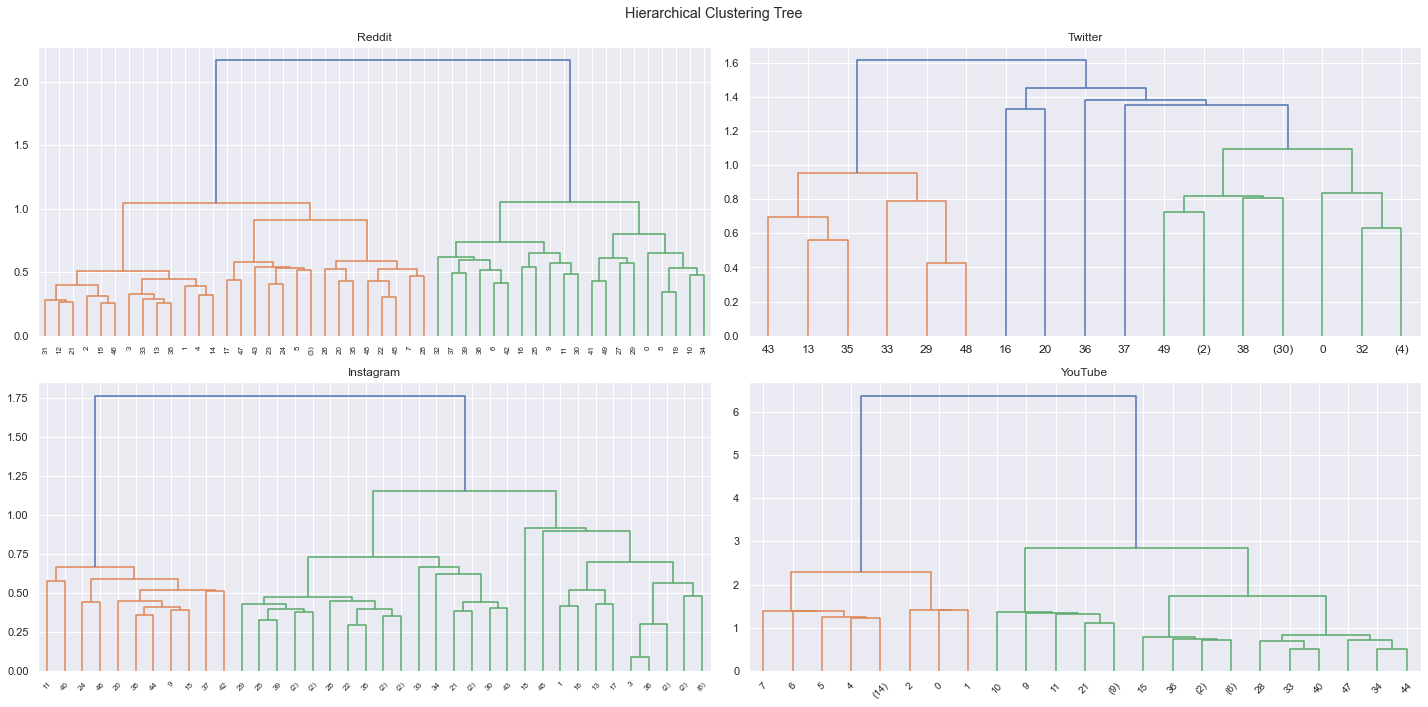

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Hierarchical Clustering Tree")

rdt_matrix = getLinkageMatrix(rdtTFVects)
scipy.cluster.hierarchy.dendrogram(rdt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 0])
axs[0, 0].set_title("Reddit")
twt_matrix = getLinkageMatrix(twtTFVects)
scipy.cluster.hierarchy.dendrogram(twt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 1])
axs[0, 1].set_title("Twitter")

ins_matrix = getLinkageMatrix(insTFVects)
scipy.cluster.hierarchy.dendrogram(ins_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[1, 0])
axs[1, 0].set_title("Instagram")
ytb_matrix = getLinkageMatrix(ytbTFVects)
scipy.cluster.hierarchy.dendrogram(ytb_matrix, p=5, truncate_mode='level', get_leaves=True, ax=axs[1, 1])
axs[1, 1].set_title("YouTube")

fig.tight_layout()
plt.show()

In [71]:
def calculateWaldClustering(TFVects, title, n, df):
    CoocMat = TFVects * TFVects.T
    linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, n, 'maxclust')
    print("Silhouetter score for " + title + " is " + 
          str(sklearn.metrics.silhouette_score(CoocMat, hierarchicalClusters_full)))
    df['wald_predictions'] = hierarchicalClusters_full
    return df

In [72]:
reddit = calculateWaldClustering(rdtTFVects, "Reddit", 6, reddit)
twitter = calculateWaldClustering(twtTFVects, "Twitter", 6, twitter)
ins = calculateWaldClustering(insTFVects, "Instagram", 6, ins)
youtube = calculateWaldClustering(ytbTFVects, "YouTube", 6, youtube)

Silhouetter score for Reddit is 0.05183393347198154
Silhouetter score for Twitter is 0.12495940319397823
Silhouetter score for Instagram is 0.06388798857806045
Silhouetter score for YouTube is 0.1448970468537995


#### Genism

In [73]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

reddit['reduced_tokens'] = reddit['normalized_tokens'].apply(lambda x: dropMissing(x, rdtTFVectorizer.vocabulary_.keys()))
twitter['reduced_tokens'] = twitter['normalized_tokens'].apply(lambda x: dropMissing(x, twtTFVectorizer.vocabulary_.keys()))
ins['reduced_tokens'] = ins['normalized_tokens'].apply(lambda x: dropMissing(x, insTFVectorizer.vocabulary_.keys()))
youtube['reduced_tokens'] = youtube['normalized_tokens'].apply(lambda x: dropMissing(x, ytbTFVectorizer.vocabulary_.keys()))

In [74]:
def conductLDAModel(df, title):
    dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
    gensim.corpora.MmCorpus.serialize(title, corpus)
    mmcorpus = gensim.corpora.MmCorpus(title)
    lda = gensim.models.ldamodel.LdaModel(corpus=mmcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
    return dictionary, lda

In [75]:
rdt_dict, rdt_lda = conductLDAModel(reddit, "Reddit")
twt_dict, twt_lda = conductLDAModel(twitter, "Twitter")
ins_dict, ins_lda = conductLDAModel(ins, "Instagram")
ytb_dict, ytb_lda = conductLDAModel(youtube, "YouTube")

#### Reddit

In [76]:
rdt_ldaDF = pd.DataFrame({'upvotes' : reddit['upvotes'], 
                         'topics' : [rdt_lda[rdt_dict.doc2bow(l)] for l in reddit['reduced_tokens']]})
topicsProbDict = {i : [0] * len(rdt_ldaDF) for i in range(rdt_lda.num_topics)}

for index, topicTuples in enumerate(rdt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(rdt_lda.num_topics):
    rdt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

rdt_ldaDF.head()

,upvotes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1,"[(0, 0.59722173), (1, 0.04291125), (2, 0.04643...",0.597222,0.042911,0.04644,0.041524,0.047206,0.043093,0.045691,0.046593,0.045611,0.043707
1,12,"[(1, 0.22881493), (4, 0.74342835)]",0.000000,0.228815,0.00000,0.000000,0.743428,0.000000,0.000000,0.000000,0.000000,0.000000
2,15,"[(7, 0.9373574)]",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.937357,0.000000,0.000000
3,2,"[(5, 0.965769)]",0.000000,0.000000,0.00000,0.000000,0.000000,0.965769,0.000000,0.000000,0.000000,0.000000
4,2,"[(1, 0.4396343), (9, 0.50830424)]",0.000000,0.439634,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.508304


In [77]:
rdt_ldaDF.sort_values(by=['upvotes'], ascending=False, inplace=True)
rdt_ldaDFV = rdt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[:10][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

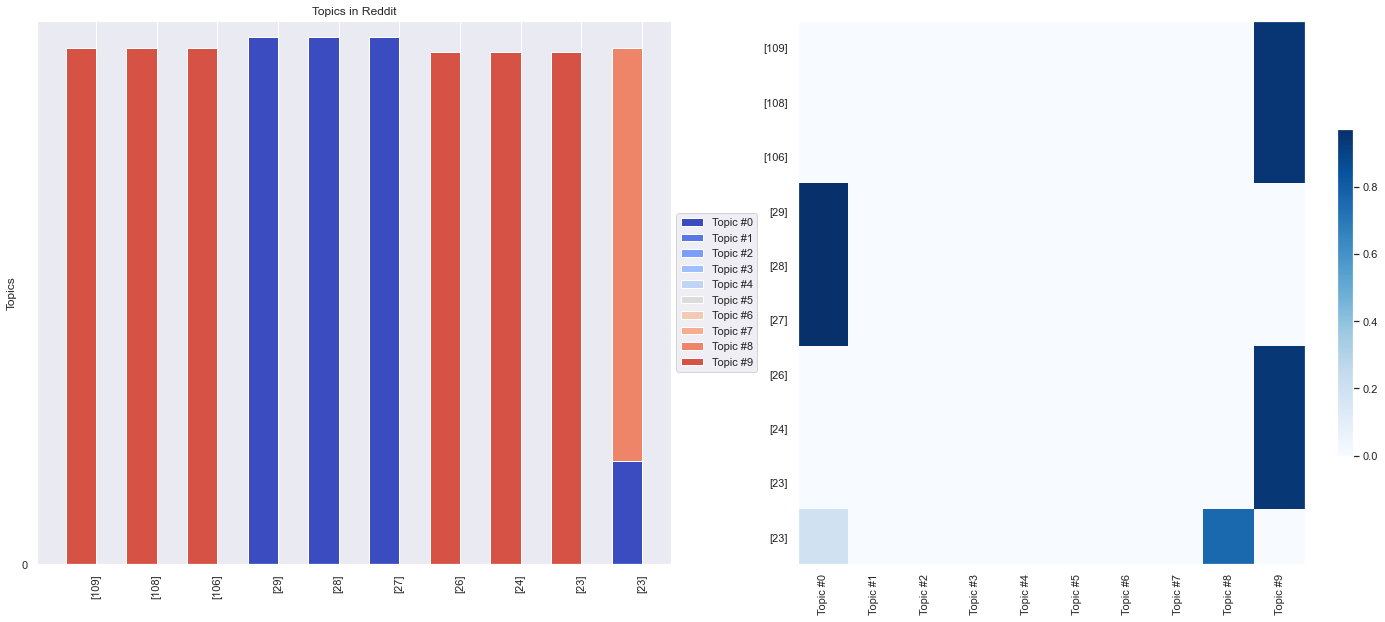

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [79]:
topicsDict = {}
for topicNum in range(rdt_lda.num_topics):
    topicWords = [w for w, p in rdt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,gymshark,sale,gymshark,gymshark,gymshark,gymshark,gymshark,gymshark,gymshark,gymshark
1,shorts,like,new,sale,like,shorts,time,sale,shorts,want
2,waist,order,waist,wondering,seamless,like,sizing,fit,seamless,sale
3,know,shorts,fit,new,vital,small,looking,like,vital,order
4,want,gymshark,small,leg,black,shirt,sale,medium,got,ve
5,medium,black,buy,waist,shorts,medium,buy,long,items,items
6,fit,going,know,bought,know,gym,small,time,like,know
7,time,items,like,long,tight,waist,seamless,ordered,waist,shipping
8,like,help,ve,seamless,got,wondering,ve,know,whitney,legging
9,small,medium,want,xs,sure,sizing,joggers,items,fit,vital


In [80]:
rdt_ldaDFV = rdt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[-10:][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

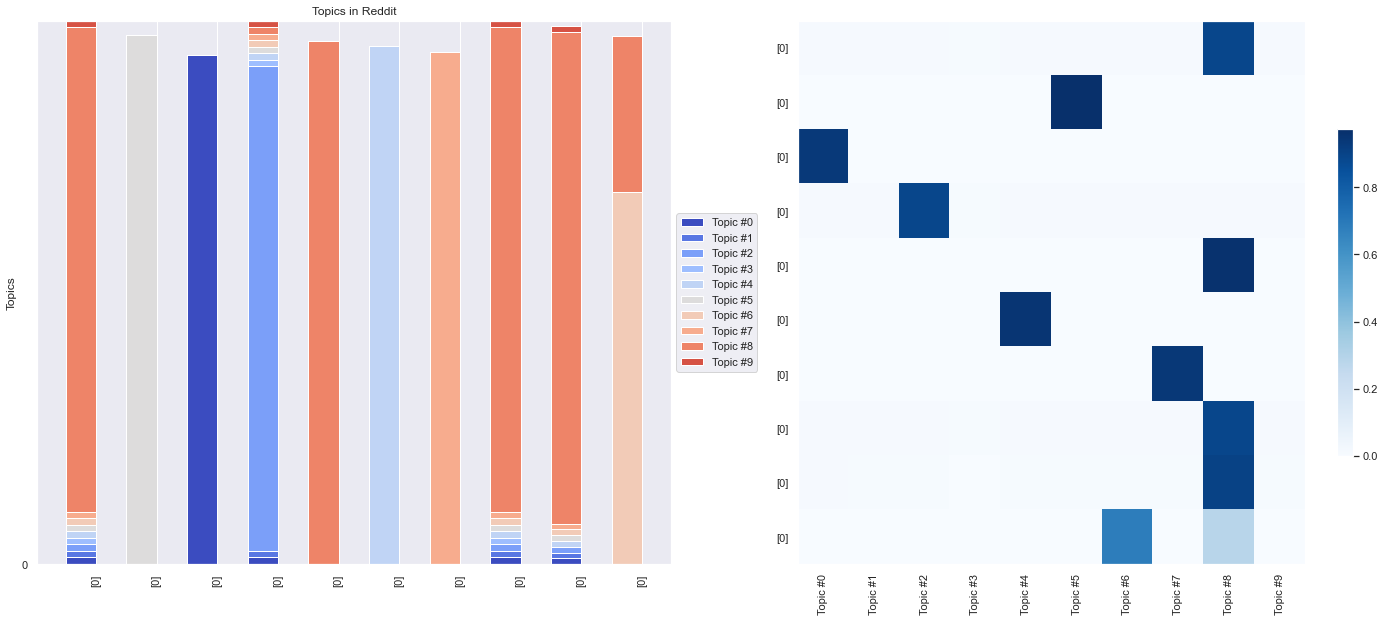

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Twitter

In [82]:
twt_ldaDF = pd.DataFrame({'favorite_cnt' : twitter['favorite_cnt'],
                         'topics' : [twt_lda[twt_dict.doc2bow(l)] for l in twitter['reduced_tokens']]})
topicsProbDict = {i : [0] * len(twt_ldaDF) for i in range(twt_lda.num_topics)}

for index, topicTuples in enumerate(twt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(twt_lda.num_topics):
    twt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

twt_ldaDF.head()

,favorite_cnt,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(0, 0.032363586), (1, 0.0308397), (2, 0.03355...",0.032364,0.030840,0.033550,0.316974,0.031979,0.031123,0.431371,0.030206,0.031464,0.030130
1,4,"[(0, 0.011893809), (1, 0.01132841), (2, 0.0123...",0.011894,0.011328,0.012324,0.010728,0.011746,0.011432,0.010966,0.011095,0.897419,0.011067
3,0,"[(0, 0.015922973), (1, 0.015168787), (2, 0.863...",0.015923,0.015169,0.863668,0.014364,0.015731,0.015309,0.014683,0.014858,0.015475,0.014821
5,0,"[(0, 0.03238885), (1, 0.030863637), (2, 0.0335...",0.032389,0.030864,0.033580,0.029225,0.032001,0.720194,0.029877,0.030230,0.031486,0.030155
6,0,"[(0, 0.019156702), (1, 0.38610944), (2, 0.0198...",0.019157,0.386109,0.019864,0.017288,0.018931,0.018424,0.017671,0.017880,0.466840,0.017835


In [83]:
twt_ldaDF.sort_values(by=['favorite_cnt'], ascending=False, inplace=True)
twt_ldaDFV = twt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[:10][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

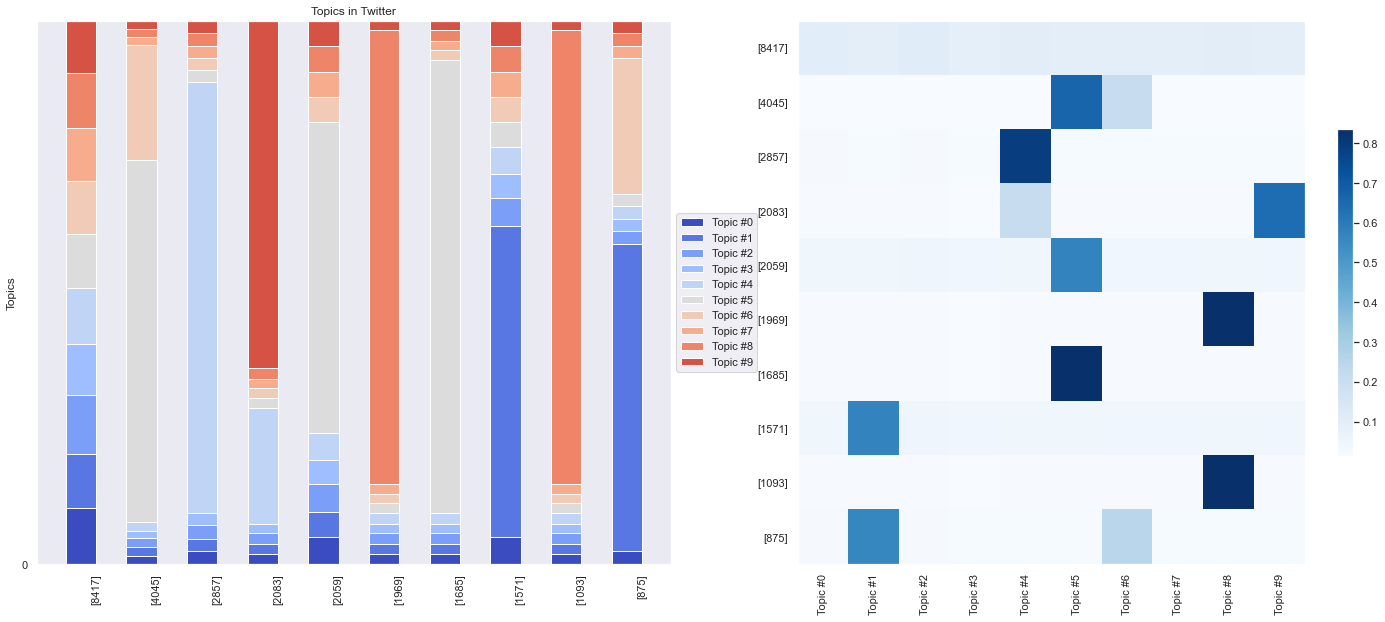

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [85]:
topicsDict = {}
for topicNum in range(twt_lda.num_topics):
    topicWords = [w for w, p in twt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,items,birthday,new,yesterday,sorry,person,like,day,thanks,let
1,good,time,day,got,want,week,thank,delivery,ha,know
2,look,summer,powerful,set,new,dm,need,colours,know,use
3,sorry,sale,wo,hi,restock,sorry,wear,red,way,place
4,check,sadly,email,love,look,happened,good,talk,looking,fabletics
5,poshmark,busy,restocking,time,plans,new,buy,sure,train,closet
6,dm,got,today,send,order,training,shark,order,hate,work
7,share,shipped,items,tho,orders,order,purchase,restocking,morning,day
8,loving,like,unfortunately,brand,super,powerful,discount,focus,love,like
9,fashion,team,wearing,training,shorts,way,sign,days,new,irl


In [86]:
twt_ldaDFV = twt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[-10:][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

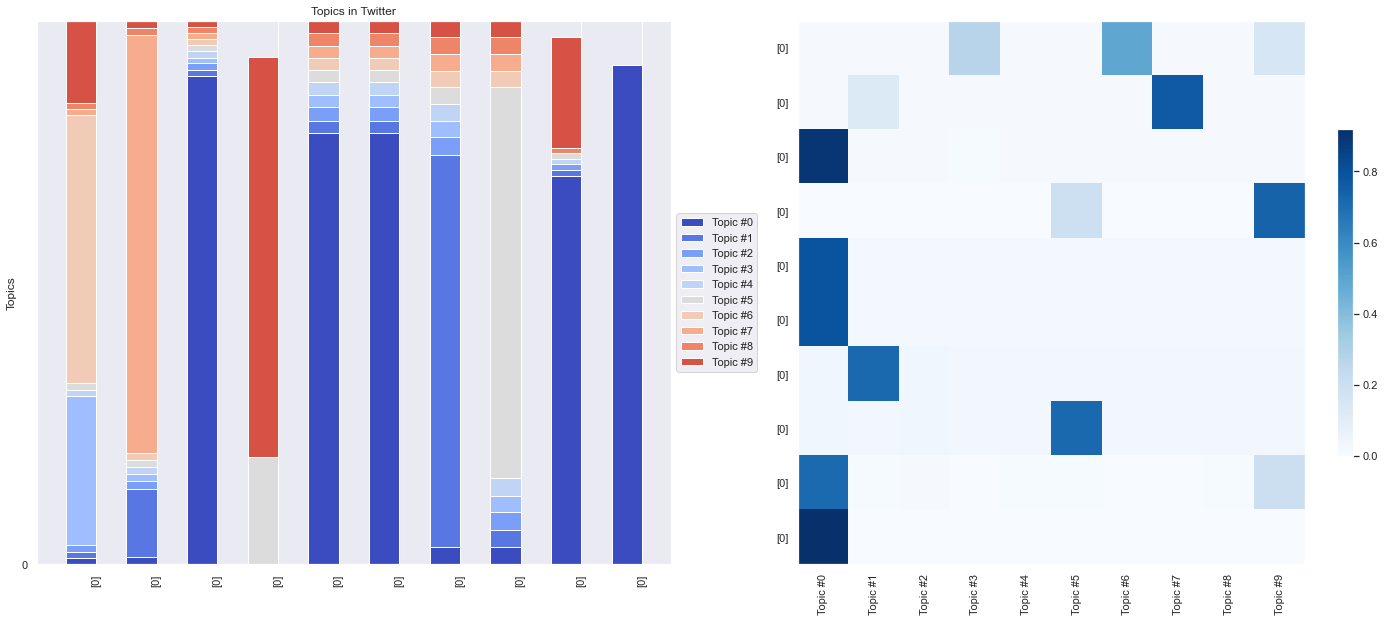

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Instagram

In [88]:
ins_ldaDF = pd.DataFrame({'likes' : ins['likes'],
                         'topics' : [ins_lda[ins_dict.doc2bow(l)] for l in ins['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ins_ldaDF) for i in range(ins_lda.num_topics)}

for index, topicTuples in enumerate(ins_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ins_lda.num_topics):
    ins_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ins_ldaDF.head()

,likes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1482,"[(0, 0.15935105), (4, 0.57574755), (5, 0.25494...",0.159351,0.000000,0.000000,0.000000,0.575748,0.254947,0.000000,0.000000,0.000000,0.000000
1,2203,"[(6, 0.75230014), (7, 0.22709846)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.752300,0.227098,0.000000,0.000000
2,4099,"[(0, 0.15914442), (2, 0.20160909), (3, 0.42563...",0.159144,0.000000,0.201609,0.425640,0.000000,0.000000,0.000000,0.201535,0.000000,0.000000
3,516,"[(0, 0.026673075), (1, 0.024916178), (2, 0.747...",0.026673,0.024916,0.747224,0.030852,0.025641,0.029162,0.026118,0.026983,0.036196,0.026234
4,150,"[(3, 0.92074215), (8, 0.0114697525)]",0.000000,0.000000,0.000000,0.920742,0.000000,0.000000,0.000000,0.000000,0.011470,0.000000


In [89]:
ins_ldaDF = ins_ldaDF[ins_ldaDF['likes'].astype(str).str.isdigit()]

In [90]:
ins_ldaDF.sort_values(by=['likes'], ascending=False, inplace=True)
ins_ldaDFV = ins_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[:10][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

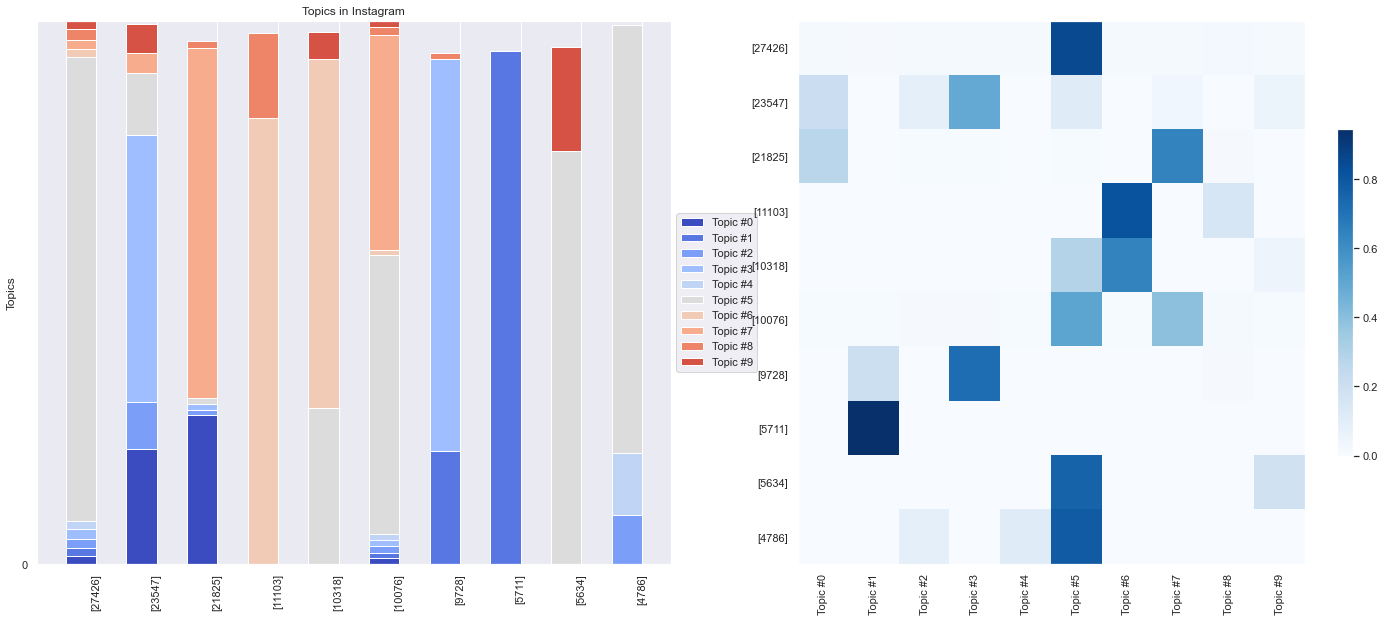

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [92]:
topicsDict = {}
for topicNum in range(ins_lda.num_topics):
    topicWords = [w for w, p in ins_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,workout,gymmotivation,work,friday,protein,set,workout,workout,gymlife,training
1,motivation,people,workout,happy,muscle,workout,love,time,fitnessmotivation,gymmotivation
2,health,beauty,fit,day,based,day,bodybuilding,like,gymmotivation,bodybuilding
3,life,gymrat,workoutmotivation,leg,day,like,fitnessmotivation,gymmotivation,workout,motivation
4,days,gymgirls,fitnessmotivation,workout,follow,sets,fashion,years,fit,body
5,story,healthylifestyle,gymlife,gymmotivation,body,body,fitnessgirl,chest,bodybuilding,gymlife
6,gymlife,fitnesslifestyle,gymsharkwomen,available,workout,weekend,gymsharkwomen,try,fitnessmodel,fit
7,workoutmotivation,fit,fitnessjourney,gymsharkwomen,link,rest,gymlife,fitnessmotivation,gymtime,healthylifestyle
8,crossfit,gymgirl,gymmotivation,weekend,love,chicken,training,gymsharktrain,fitfam,lifestyle
9,love,week,fitnessmodel,yoga,seeing,upper,muscle,training,fitnessaddict,nutrition


In [93]:
ins_ldaDFV = ins_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[-10:][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

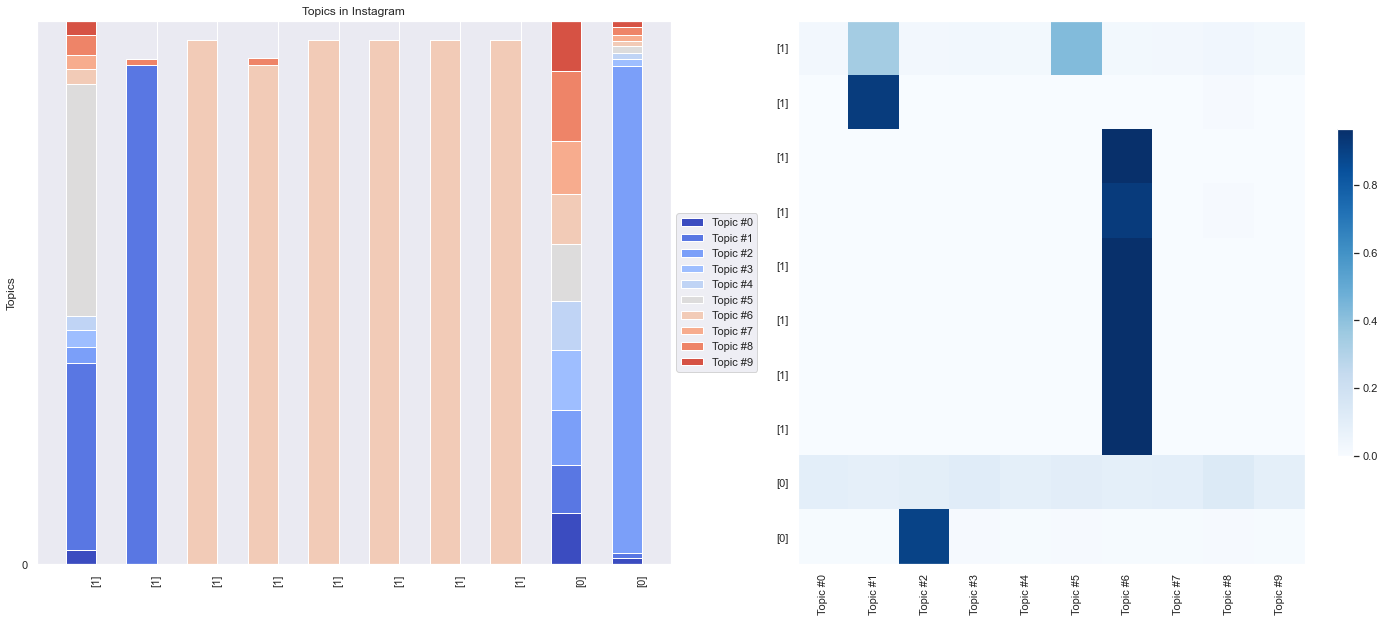

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### YouTube

In [95]:
ytb_ldaDF = pd.DataFrame({'likeCount' : youtube['likeCount'],
                         'topics' : [ytb_lda[ytb_dict.doc2bow(l)] for l in youtube['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ytb_ldaDF) for i in range(ytb_lda.num_topics)}

for index, topicTuples in enumerate(ytb_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ytb_lda.num_topics):
    ytb_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ytb_ldaDF.head()

,likeCount,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,41450,"[(2, 0.6578545), (6, 0.32454568), (9, 0.014267...",0.000000,0.000000,0.657854,0.0,0.000000,0.000000,0.324546,0.000000,0.0,0.014268
1,1331,"[(2, 0.6870091), (6, 0.2703202), (9, 0.03417669)]",0.000000,0.000000,0.687009,0.0,0.000000,0.000000,0.270320,0.000000,0.0,0.034177
2,1353,"[(1, 0.014252312), (2, 0.6860046), (6, 0.26539...",0.000000,0.014252,0.686005,0.0,0.000000,0.000000,0.265395,0.000000,0.0,0.031488
3,3045,"[(0, 0.42823488), (4, 0.012056191), (5, 0.0117...",0.428235,0.000000,0.000000,0.0,0.012056,0.011744,0.000000,0.534125,0.0,0.012098
4,13389,"[(9, 0.98100305)]",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.981003


In [105]:
ytb_ldaDF = ytb_ldaDF[ytb_ldaDF.likeCount.str.isnumeric()]
ytb_ldaDF["likeCount"] = ytb_ldaDF["likeCount"].astype(str).astype(int)

In [106]:
ytb_ldaDF.sort_values(by=['likeCount'], ascending=False, inplace=True)
ytb_ldaDFV = ytb_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[:10][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

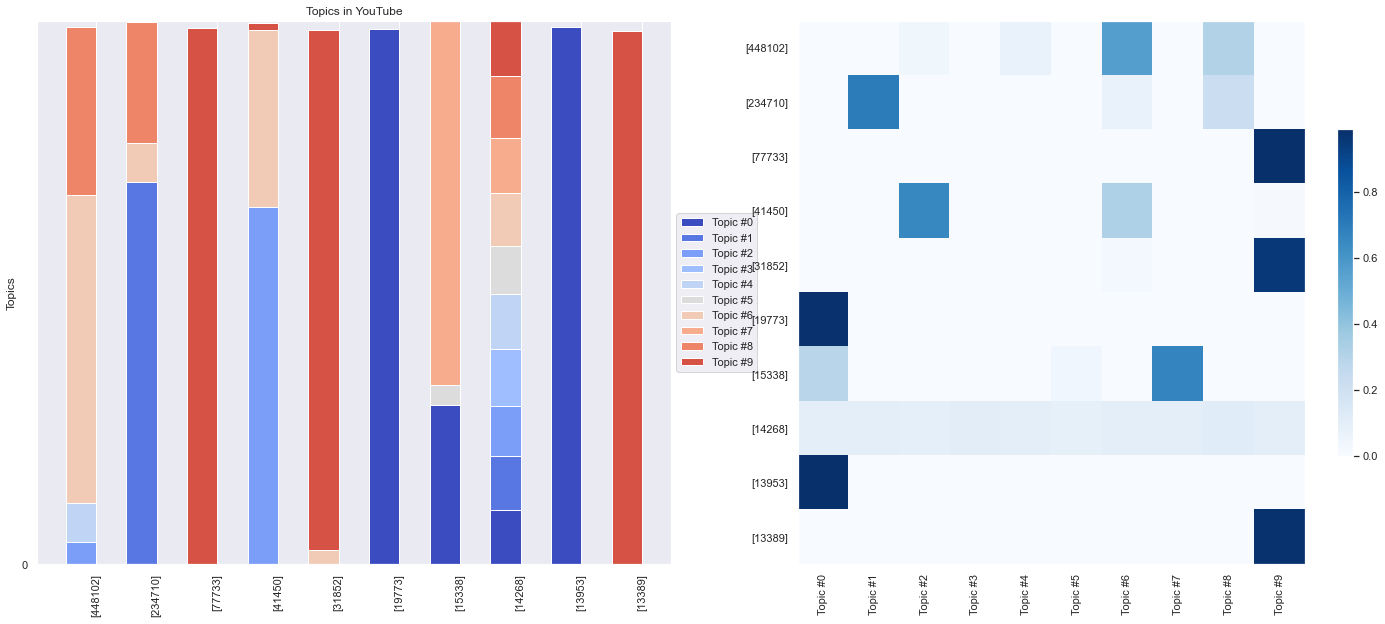

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [108]:
topicsDict = {}
for topicNum in range(ytb_lda.num_topics):
    topicWords = [w for w, p in ytb_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,sports,said,looks,okay,fit,definitely,big,definitely,fit,looks
1,bra,work,said,stuff,high,sports,work,bra,things,um
2,definitely,okay,business,said,mean,black,need,um,um,okay
3,small,stuff,stuff,super,okay,medium,stuff,wear,definitely,fit
4,super,mean,probably,work,black,okay,cool,sports,mean,super
5,workout,great,medium,long,small,seamless,trying,fit,okay,wear
6,probably,um,work,ones,medium,um,said,things,stuff,stuff
7,okay,workout,workout,black,shirt,shorts,workout,large,need,ones
8,stuff,looks,mean,things,probably,fit,wear,looks,big,workout
9,color,body,check,definitely,ones,mean,okay,workout,probably,long


In [109]:
ytb_ldaDFV = ytb_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[-10:][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

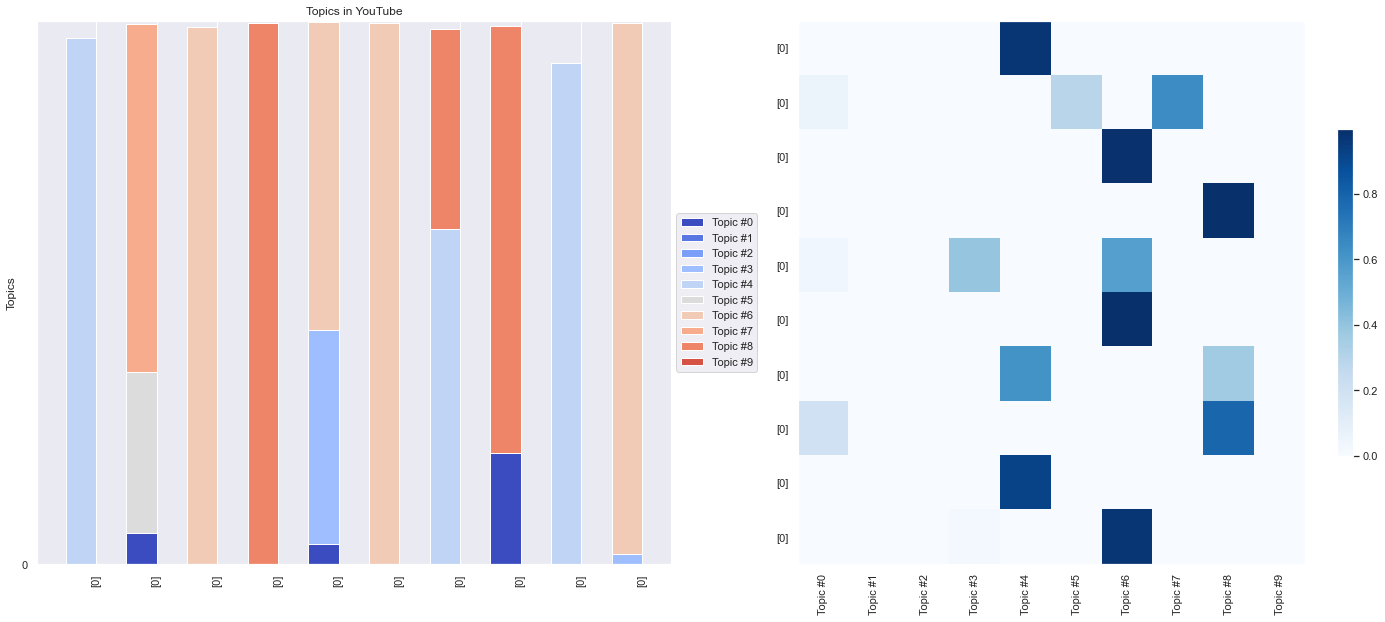

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### NLTK Topic Modeling

In [102]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(lemmas, min_count=5):
    bigram = models.Phrases(lemmas, min_count)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in lemmas]

def make_bag_words(lemmas):
    dictionary = corpora.Dictionary([i for i in lemmas])
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    return dictionary, bow_corpus

In [103]:
def nltkTopicModeling(df_list, title_list, num_topics=3, num_words=20):
    for i in range(len(df_list)):
        print("Topic Modeling for " + title_list[i])
        text = df_list[i].text.apply(get_lemmas)
        dic, bow = make_bag_words(make_bigrams(text))
        model = models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word=dic, passes=20, iterations=400)
        print(model.print_topics(num_words=num_words))
        print("\n")

In [104]:
nltkTopicModeling(df_lst, title_lst)

Topic Modeling for Reddit
[(0, '0.034*"’" + 0.015*"gymshark" + 0.014*"get" + 0.013*"size" + 0.009*"legging" + 0.008*"like" + 0.008*"\'m" + 0.007*"help" + 0.006*"medium" + 0.006*"fit" + 0.006*"look" + 0.006*"go" + 0.006*"n\'t" + 0.006*"would" + 0.005*"tight" + 0.005*"shirt" + 0.005*"order" + 0.005*"know" + 0.005*"anyone" + 0.004*"short"'), (1, '0.020*"sale" + 0.020*"gymshark" + 0.016*"item" + 0.015*"order" + 0.014*"get" + 0.011*"’" + 0.010*"sell" + 0.008*"want" + 0.007*"stock" + 0.006*"new" + 0.006*"update" + 0.006*"restock" + 0.006*"day" + 0.006*"go" + 0.005*"long" + 0.005*"make" + 0.005*"time" + 0.005*"like" + 0.005*"shipping" + 0.005*"return"'), (2, '0.035*"’" + 0.025*"size" + 0.021*"gymshark" + 0.020*"legging" + 0.013*"get" + 0.011*"short" + 0.008*"look" + 0.008*"order" + 0.008*"\'m" + 0.008*"small" + 0.007*"anyone" + 0.007*"want" + 0.007*"fit" + 0.006*"would" + 0.006*"wear" + 0.006*"waist" + 0.006*"try" + 0.006*"5" + 0.006*"pair" + 0.006*"like"')]


Topic Modeling for Twitter
[(0, 